# Start Here 

This notebook contains structured, annotated code that when run through in entirety recreates the analysis done for the paper. The preprocessing section takes the raw data into a format ready for analysis. The main experiment analysis and saline experiment analysis perform statistics and generate plots for the main experiment and the control saline experiment respectively. 

Most of the code relies on the experimental parameters in the experiment_config.json. One can change parameters there and then re-run to see the effect of changing different parameters of the study (such as number of permutations, frequency range for alpha band, etc.). Additionally, a lot of the code is packaged into functions in either the data_processing.py, statistics.py, or plotting.py which is then imported here to run.

Note that a lot of the code is quite memory and computationally intensive. It was written for and run on a machine with 64GB of memory, up to 24 available cores for parallel computation, and 1 TB of disk space. As such, one needs a fair amount of space and computing resources for some of the steps (and you will need to adjust the number of parallel threads accordingly).

It is recommended that you use this notebook with the table of contents notebook extension as one can then interactively navigate through different sections.

# Preprocessing

This section takes the data from the original blackrock data format to a compressed numpy array containing a time-frequency power representation. Be sure to first run the the cell below to create the data folder hierarchy. One can try to re-create the full process from the original blackrock data, but this requires manually extracting the stimulation onsets and offsets and data from the blackrock format. Alternatively, the preprocessing is fully automated from the Generate Stimulation Onset & Offset Locked Epochs section on. 

In [ ]:
import os
if not os.exists('../data/raw/original_raw'):
    os.makedirs('../data/raw/original_raw')
if not os.exists('../data/raw/manual_events'):
    os.makedirs('../data/raw/manual_events')
if not os.exists('../data/raw/matlab_extracted'):
    os.makedirs('../data/raw/matlab_extracted')
if not os.exists('../data/power'):
    os.makedirs('../data/power')
if not os.exists('../data/epochs'):
    os.makedirs('../data/epochs')

## Extract .mat Files from the Blackrock Raw Files

** Blackrock Data Files **

Blackrock raw data files come in their own format: http://support.blackrockmicro.com/KB/View/166838-file-specifications-packet-details-headers-etc

Luckily, we don't need too much knowledge of the inner workings of their data formats for two reasons:

1. All of the recorded neural data live in the .ns2 suffixed files in the raw > blackrock_original_data folder. These files house all of the actual electrode recordings from the implanted arrays. The other files we are interested in are the .ns5 files. These files contain an analog input channel that holds a copy of the feedback stimulation waveform. We will also extract this input in order to compare it with our controlling electrode to see how successfully we suppressed artifact from the stimulation. See the above link for descriptions of what the other files in this folder contain. 
2. Blackrock has a toolkit <a href="http://support.blackrockmicro.com/KB/View/166898-matlab-interfacing-and-analysis">NPMK</a> for extracting data from their file formats into MATLAB structs. I used this toolkit to extract the data as detailed below.

** Extracting the Data with NPMK **

1. First, I downloaded the NPMK (v. 4.4.0.0) toolkit folder via the instructions in the link above.
2. Then I executed the following two lines in the MATLAB command line so that matlab will find the NPMK functions ($software should be replaced with the path to where you downloaded the toolkit):

        addpath '$software/NPMK-4.4.0.0/NPMK/'
 addpath '$software/NPMK-4.4.0.0/NPMK/Dependent Functions'
        
3. Type 'openNSx' at the command prompt. Then select the desired .ns2 or .ns5 file from data/raw/blackrock_original_data and click open via the gui that pops up.
4. Save the resulting matlab struct with the following command where DATE gets replaced with the date in the filename (or saline for the saline test), 'NS2' or 'NS5' is the name of the extracted struct object, and '-v7.3' uses a version of save that supports larger file sizes (this assumes matlab's current directory is the project's base directory):

        save('data/raw/matlab_extracted_data/DATE_ns(2|5).mat', 'NS(2|5)', '-v7.3')

5. Repeat separately for each date's .ns2 and .ns5 file.

## Create Raw FIF files from Extracted .mat Files 

Unfortunately, Fieldtrip's functions for converting blackrock data into fieldtrip format are not fully functional. Because of this, I decided to just manually construct a raw object from the .mat file with MNE since I have a better understanding of the inner workings of MNE raw objects.

To do so I scrape out the bare minimum information needed to make an analyzable raw object:
  - The names of the channels.
  - The sampling rate.
  - The actual data.
  - The digital to analog scaling factor.

I store the data as 'EEG' channels because MNE does not have explicit representations for intracranial recordings. Note that the data needs to be scaled appropriately to convert from digitized units to microvolts. Additionally, I add an extra STIM channel with all 0's to be used to designate the stimulation events extracted in the next step.

In [3]:
import numpy as np
from mne import create_info
from mne.io import RawArray
import glob
import re
from data_processing import extract_blackrock_info, create_mne_raw

# iterate through raw data files
fnames = sorted(glob.glob('../data/raw/matlab_extracted_data/*ns*.mat'))
for f in fnames:
    
    # extract date and recording type info from file name
    search = re.search('(\d{7}|saline).*(ns2|ns5)', f)
    typ, date = search.group(2), search.group(1)
    print('Creating Raw %s fif File for Date: %s' %(typ, date))
    
    # extract blackrock recording info and data
    blackrock_info = extract_blackrock_info(f, typ)
    
    # create the MNE raw object
    raw = create_mne_raw(blackrock_info)
    
    # save out to file
    raw.save('../data/raw/original_raw/%s_%s_raw.fif' %(date, typ), 
             verbose=False, overwrite=True)

print('Done!')

Creating Raw ns2 fif File for Date: 9012016
Creating Raw ns5 fif File for Date: 9012016
Creating Raw ns2 fif File for Date: 9022016
Creating Raw ns5 fif File for Date: 9022016
Creating Raw ns2 fif File for Date: 9062016
Creating Raw ns5 fif File for Date: 9062016
Creating Raw ns2 fif File for Date: 9072016
Creating Raw ns5 fif File for Date: 9072016
Creating Raw ns2 fif File for Date: saline
Creating Raw ns5 fif File for Date: saline
Done!


## Manually Extract Stimulation Period Events 

Unfortunately, all of the timing of stimulation was done manually (meaning it isn't very precise) and none of the stimulation onsets & offsets were recorded in stim channels. Consequently, these stimulation events need to be extracted from the data. I tried playing around with some automatic extraction techniques, but overall found manual extraction to be more reliable.

Thus, I manually extracted events as follows:

1. Load the data in mne_browse_raw (File > Open)
2. Load the corresponding channel selections file so the data is visible (File > Load Channel Selections). Select either the .ns2 or the .ns5 file accordingly.
3. Set the viewing scale to be large (Adjust > Scales > EEG = 5e7) so the stimulation periods stand out. 
4. Turn off the average reference projection (Adjust > Projection > All On/Off).
3. Go through and manually mark both the onset and offset of stimulation periods as user-defined events. First open the annotator (Windows > Show Annotator). Scroll through the data and then click at the onsets and offsets of the stimulation periods and hit mark on the first row of the annotator to set a user-defined event. I used the view containing elec's 1-83, 82, 85 etc. since these are the electrodes neighboring the electrode being used to form the closed loop. 
4. Save these defined events to a file: "./raw/manual_events/DATE_partX-eve.fif" where X refers to the file number for that date (necessary since some dates were split into multiple fif files and thus needed to be viewed and marked separately). Make sure that the comment in the annotator for each event is either blank or starts with a # or you will need to go in and add a # to the final column.
5. Repeat Steps 1-4 for each day of recording (some days were too big for a single fif file so this step is actually repeated for each fif file, the fif files for a single day will later get concatenated together).
6. Next, these events are loaded, morphed into square waves, and added to the STIM channel in the raw fif files (code below). The modified raw data with the events encoded in the stim channel is saved out. Note: This step is not necessary, but it helped me to visually verify the manual selections I had made after the fact and ensure that all of the data and events were encoded into the same fif file at the expense of extra storage space.
7. Finally, I visually sanity check the raw with the stim channel added to make sure I have appropriately encoded the stimulation periods in the stim channel.

** Notes on Raw Recordings/Stim Periods **

- 9/6/2016: One of the brain trial runs had an extra trial (11 instead of 10) as documented in the lab notebook pictures. Rather, than adjust the code to account for this outlier, I just didn't mark the stim events for the final trial so that there were only 10 instead of 11 trials.  


In [6]:
from mne.io import Raw
from mne import read_events
import glob, re
import numpy as np
import pandas as pd
from data_processing import create_events_square_wave

raw_fnames = sorted(glob.glob('../data/raw/original_raw/*ns2*_raw.fif'))
event_fnames = sorted(glob.glob('../data/raw/manual_events/*-eve.txt'))
condition_df = pd.read_csv('../lab_notebook/condition_info.csv', 
                           dtype={'Date':str, 'Trial':int, 'Block':int, 
                                  'Condition':int})
dates = condition_df.Date.unique()

for date in dates:
    
    if date != 'saline': continue
    print('Adding Stim Events for Date: %s' % date)
    
    # load mne events (concatenate multiple files for date) 
    events_fs = [f for f in event_fnames if date in f] 
    events = [read_events(f)[1:, :] for f in events_fs]
    events = np.concatenate(events, axis=0)
    
    # create new events 'filled in' so that they will form square waves
    # representing duration of stimulation
    filled_events = create_events_square_wave(events)
        
    # add events to raw & save 
    for typ in ['ns2', 'ns5']:
        raw = Raw('../data/raw/original_raw/%s_%s_raw.fif' % (date, typ), 
                  verbose=False, preload=True)
        # re-sample down to ns2 sampling rate to allow for matching of
        # event timing
        if typ == 'ns5':
            raw.resample(1000)
        raw.add_events(filled_events, stim_channel='STIM')
        f = '../data/raw/manual_events/%s_%s_with_manual_events_raw.fif' 
        raw.save(f % (date, typ), overwrite=True)
    
print('Done!')

Adding Stim Events for Date: saline
Done!


## Generate Stimulation Onset & Offset Locked Epochs

With our onset and offset events encoded, we next epoch the data below. Since the timing of the stimulation wasn't precisely 10 seconds, I chose to epoch separately to the onset and offset of the stimulation. This will then allow us to stitch the first 5 seconds of the post-onset stimulation with the last 5 seconds of the pre-offset stimulation to create standardized ten second stimulation periods.

In [7]:
from mne.io import Raw, set_eeg_reference
from mne import find_events, Epochs, concatenate_raws, set_log_level
import numpy as np
import glob
import json
import re
import pandas as pd
import pylab as plt
set_log_level('critical')   

# load experiment configuration info
with open('./experiment_config.json', 'r') as f:
    config = json.load(f)

# raw filenames & condition info
fnames = glob.glob('../data/raw/manual_events/*ns2*raw.fif')
condition_df = pd.read_csv('../lab_notebook/condition_info.csv', 
                           dtype={'Date':str, 'Trial':int, 'Block':int, 
                                  'Condition':int})
dates = condition_df.Date.unique()

for date in dates:
    
    if date != 'saline': continue
    print('Creating Epochs for Date: %s' %(date))
    
    if date == '9012016':
        # no brain condition first day
        event_id = dict(Open=0, Closed=1)
    else:
        event_id = dict(Open=0, Closed=1, Brain=2)
    
    for typ in ['ns2', 'ns5']:
        print(typ)
    
        # load & concatenate raws
        date_raw_files = sorted([f.replace('ns2', typ) for f in 
                                 fnames if date in f])
        raws = [Raw(f, preload=True, verbose=False) for f in date_raw_files]
        raw = concatenate_raws(raws)
    
        # Remove existing references
        set_eeg_reference(raw, [])
        for i in range(len(raw.info['projs'])):
            raw.del_proj(-1)
    
        # bandpass filter
        raw.filter(l_freq=config['highpass'], h_freq=config['lowpass'],
                   n_jobs=config['n_jobs'])

        for epo_type in ['onset', 'offset']:
            
            # extract events
            events = find_events(raw, stim_channel='STIM', output=epo_type, 
                                 verbose=False)
    
            # encode stimulation type in the event markers
            conditions = condition_df[condition_df.Date == date].Condition 
            events[:, -1] = np.array(conditions)
            print(events.shape)
    
            # Generate & Save Epochs 
            epochs = Epochs(raw, events=events, event_id=event_id, 
                            tmin=-config['epoch_width'], 
                            tmax=config['epoch_width'], 
                            add_eeg_ref=False, preload=True,
                            reject_by_annotation=False)
            print(epochs.get_data().shape)
            epochs.save('../data/epochs/%s_%s_stim_%s-epo.fif' %(date, typ, 
                                                                 epo_type))

print('Done!')

Creating Epochs for Date: saline
ns2
(90, 3)
(90, 129, 20001)
(90, 3)
(90, 129, 20001)
ns5
(90, 3)
(90, 4, 20001)
(90, 3)
(90, 4, 20001)
Done!


## Generate Time Frequency Power 

The final step in the preprocessing pipeline is to create a time-frequency power representation of the data since we want to compare post-stimulation power changes. The cell below takes in the onset and offset-locked epochs, transforms them to a tfr representation using MNE-Python's morlet wavelet convolution, and then concatenates the onset and offset tfr epochs together resulting in a separate tfr power representation for each condition on each date of recording that is saved out to disk. The onset and offset epochs are stitched together by taking the first 5 seconds of post-onset stimulation and the last 5 second of pre-offset stimulation and joining these together. This is not exact since the stimulation did not last exactly 10 seconds every trial, but instead coerces every trial into a consistent length where the stimulation period is approximately equivalent to the actual stimulation period.

Since we are interested in the alpha and beta band, we restricted the frequencies of interest between 5 and 30 Hz. Similarly, we selected a number of cycles equivalent to the frequency resulting in a 1 second temporal resolution at every frequency. We didn't expect to resolve fine temporal changes, but instead were interested in gross power changes in a larger post-stimulation period. Because of this we chose the relatively poor 1 second temporal resolution in order to better resolve particular frequency content consistently across frequencies. 

In [8]:
from mne.time_frequency import tfr_morlet 
from mne import read_epochs, set_log_level
import numpy as np
import glob, re
import json
import os
set_log_level('critical')

# load experiment configuration info
with open('./experiment_config.json', 'r') as f:
    config = json.load(f)

on_fnames = sorted(glob.glob('../data/epochs/*stim_onset-epo.fif'))
off_fnames = sorted(glob.glob('../data/epochs/*stim_offset-epo.fif'))

# TFR parameters (num_cycles and frequencies matched to give 1 sec
# temporal resolution at every frequency)
freqs = np.arange(5, 31, 1) 
n_cycles = freqs 

for on_f, off_f in zip(on_fnames, off_fnames):

    search = re.search('(\d{7}|saline).*(ns(2|5))', on_f)
    typ, date = search.group(2), search.group(1)
   
    if date != 'saline': continue
    print('Computing %s Power for Date: %s' %(typ, date))

    # load epoched data
    on_epochs = read_epochs(on_f, verbose=False)
    off_epochs = read_epochs(off_f, verbose=False)

    # loop through conditions
    conditions = list(on_epochs.event_id.keys())
    for condition in conditions:
        print('Condition: %s' %(condition))
        
        # compute TFR power using Morlet Wavelet Convolution
        on_power_epochs = tfr_morlet(on_epochs[condition], freqs=freqs, 
                                     n_cycles=n_cycles, use_fft=True, 
                                     decim=config['decim'], 
                                     return_itc=False, average=False, 
                                     n_jobs=config['n_jobs'])
        
        off_power_epochs = tfr_morlet(off_epochs[condition], freqs=freqs, 
                                      n_cycles=n_cycles, use_fft=True, 
                                      decim=config['decim'], 
                                      return_itc=False, average=False, 
                                      n_jobs=config['n_jobs'])

        # merge onset and offset power stitching together first 5 
        # seconds of post-onset power and first 5 seconds of pre-offset
        # power
        epoch_width = config['tfr_epoch_width']
        on_power_epochs.crop(-epoch_width, 4.99)
        off_power_epochs.crop(-5, epoch_width)

        times = np.concatenate([on_power_epochs.times, 
                                off_power_epochs.times + 10])
        chs = on_power_epochs.ch_names

        trial_data = np.concatenate([on_power_epochs.data, 
                                     off_power_epochs.data], 
                                    axis=-1)
        
        # save out the raw tfr power
        f = '../data/power/%s_%s_%s_raw_power.npz'
        np.savez_compressed(f % (typ, condition, date), 
                            data=trial_data, chs=chs, times=times, 
                            freqs=freqs)
    
print('Done!')

Computing ns2 Power for Date: saline
Condition: Brain
Condition: Open
Condition: Closed
Computing ns5 Power for Date: saline
Condition: Brain
Condition: Open
Condition: Closed
Done!


# Main Experiment Analysis

This sections performs statistical testing and visualizing for the main experiment investigating the effect of closed loop stimulation on neural oscillatory activity. Be sure to run the cell below first to create the necessary output folders. 

In [5]:
import os

if not os.path.exists('../plots/main_experiment'):
    os.makedirs('../plots/main_experiment')
if not os.path.exists('../stats/main_experiment'):
    os.makedirs('../stats/main_experiment')

## Plot Before, During, and After Spectra



In [ ]:
from supporting_functions import plot_before_during_after_spectra

%matplotlib inline

fig = plot_before_during_after_spectra('main')

fig.savefig('./plots/main_experiment/main_exp_before_during_after_spectra.png')
fig.show()

## Compare Post-Stim Power Changes Between Conditions

### Bootstrap Test for Comparing to Baseline

#### Pre-Compute Bootstrap Indices

In [ ]:
from supporting_functions import pre_compute_bootstrap_indices

pre_compute_bootstrap_indices('main')

#### Compute the Bootstrap Distributions 

In [ ]:
from supporting_functions import compute_bootstrap_distribution

compute_bootstrap_distribution('main')

#### Plot the Bootstrap TOI Distributions

In [ ]:
from supporting_functions import plot_bootstrap_distributions

fig = plot_bootstrap_distributions('main')

fig.savefig("./plots/main_experiment/main_condition_bootstrap_distributions.png")
fig.show()

### Permutation Test for Comparing Conditions

#### Pre-Compute Permutation Indices

In [ ]:
from supporting_functions import pre_compute_permutation_indices

pre_compute_permutation_indices('main')

#### Pre-Compute Sub-Sample Indices

In [ ]:
from supporting_functions import pre_compute_subsample_indices

pre_compute_subsample_indices('main')

#### Compute the Permutation Distributions

In [ ]:
from supporting_functions import compute_permutation_distributions

compute_permutation_distributions('main')

#### Plot the Permutation Distributions

In [ ]:
from supporting_functions import plot_permutation_distributions

fig = plot_permutation_distributions('main')
fig.savefig('./plots/main_experiment/main_condition_permutation_dists.png')
fig.show()

### Plot Condition TOI Comparison 

In [ ]:
from supporting_functions import plot_condition_toi_comparison

fig = plot_condition_toi_comparison('main')
fig.savefig('./plots/main_experiment/main_condition_toi_comparison.png')

### Plot Condition Band Comparison

In [ ]:
from supporting_functions import plot_condition_toi_comparison

fig = plot_condition_toi_comparison('main')
fig.savefig('./plots/main_experiment/main_condition_toi_comparison.png')

## Compare Post-Stim Power Changes Between Recording Arrays

### Permutation Test for Comparing Arrays

#### Compute the Permutation Distributions

In [1]:
from statistics import compute_array_permutation_distribution

compute_array_permutation_distribution('main')

Open
Closed
Brain
Done!


#### Plot the Permutation Distributions

/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


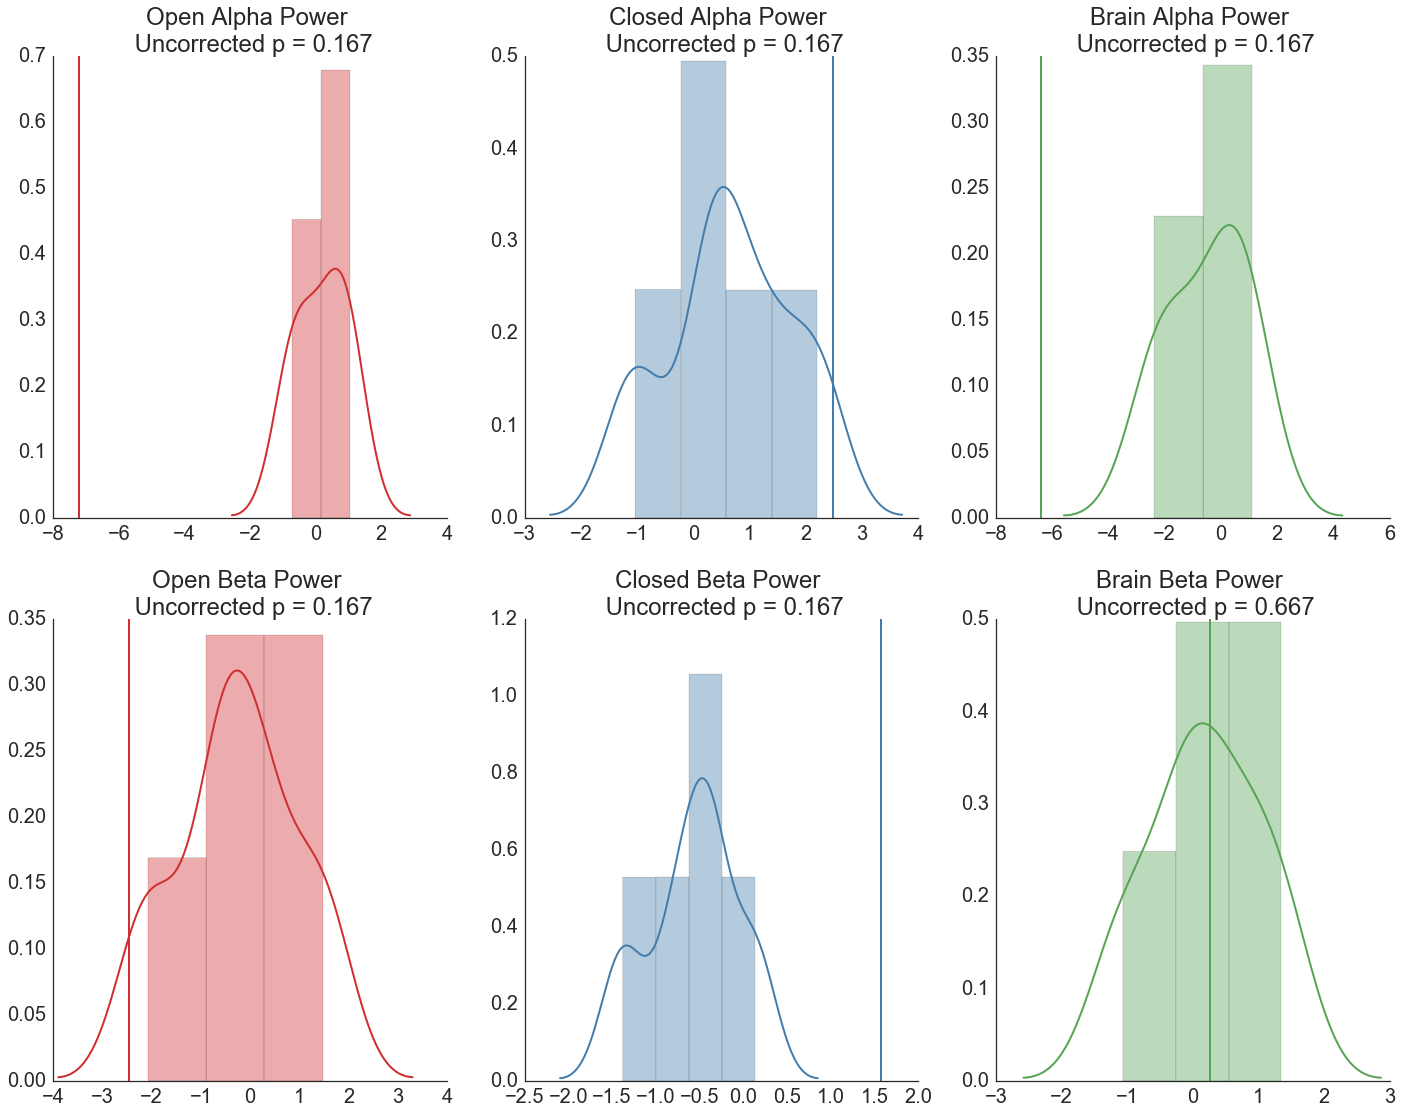

In [1]:
from plotting import plot_array_permutation_distributions

%matplotlib inline

fig = plot_array_permutation_distributions('main')

fig.savefig('../plots/main_experiment/array_permutation_dists.png')
fig.show()

### Plot Array TOI Comparison

/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


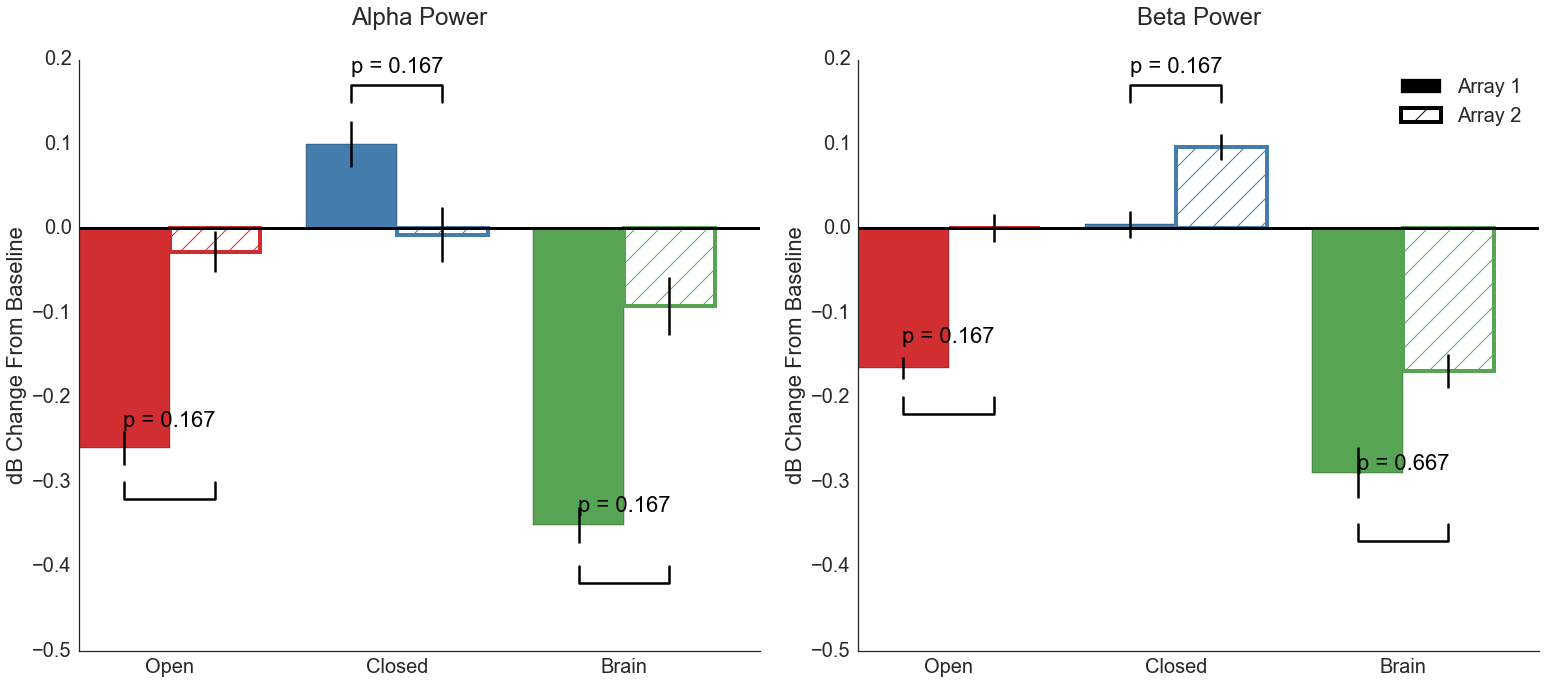

In [1]:
from plotting import plot_array_toi_comparison

%matplotlib inline

fig = plot_array_toi_comparison('main')

fig.savefig('../plots/main_experiment/main_array_toi_comparison.png')
fig.show()

### Plot Array Band Comparison

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (62,) (902,) 

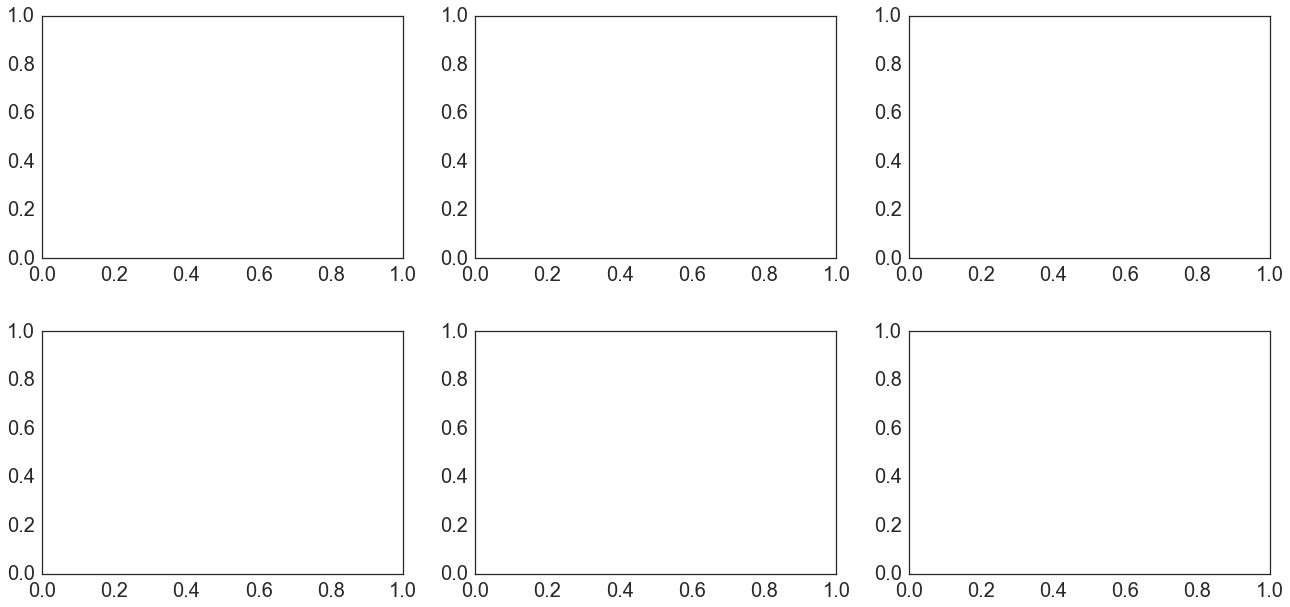

In [1]:
from plotting import plot_array_band_comparison

%matplotlib inline

fig = plot_array_band_comparison('main')

fig.savefig('../plots/main_experiment/main_array_band_comparison.png')
fig.show()

## Plot Early vs. Late Stimulation Spectra 

/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


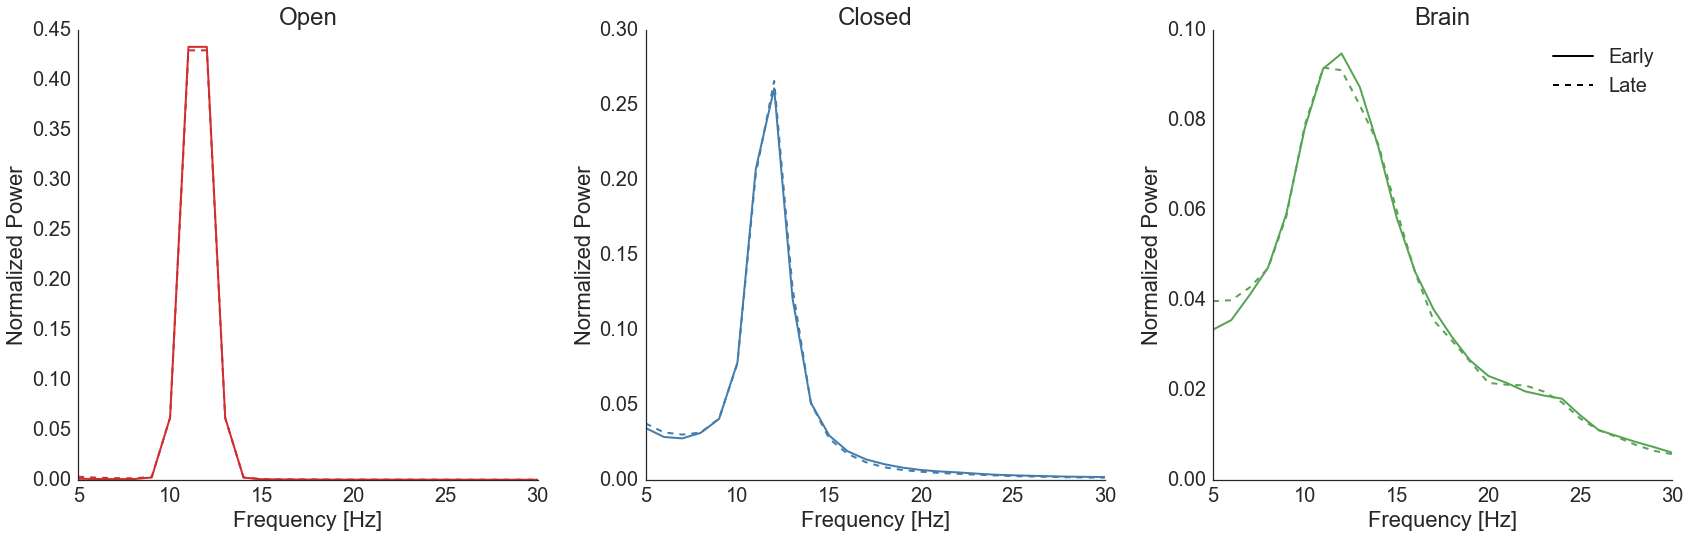

In [1]:
from plotting import plot_early_vs_late_stim_spectra

%matplotlib inline

fig = plot_early_vs_late_stim_spectra('main')

fig.savefig('../plots/main_experiment/early_vs_late_stim_spectra.png')
fig.show()

## Spectra of controlling electrode during stimulation

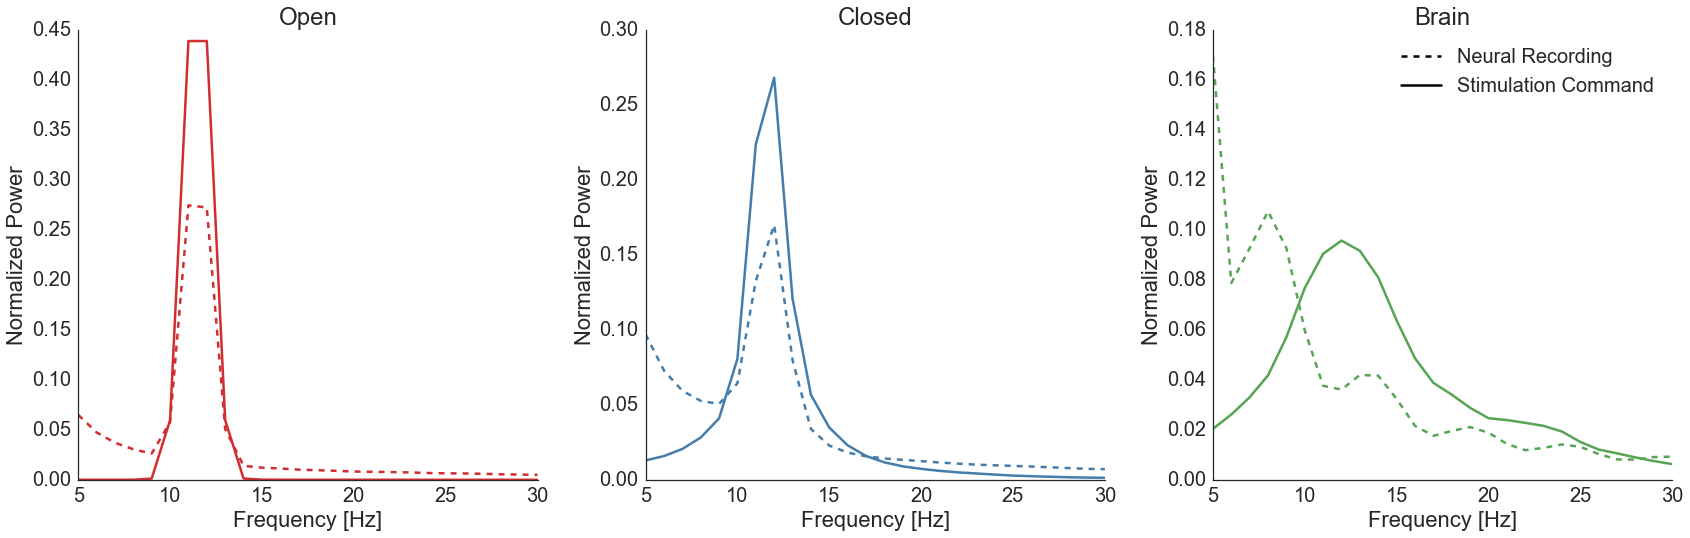

In [37]:
import pylab as plt
import seaborn as sns
import numpy as np
import glob

sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')

indices = {'Before': (-1, -.5), 'During': (0, 10), 'After': (10.5, 11)}
conditions = ['Open', 'Closed', 'Brain']
colors = COLORS[:3]
        
f, axs = plt.subplots(1, 3, figsize=(24, 8))

conditions = ["Open", "Closed", "Brain"]
types = ['ns2', 'ns5']
legend = ['Neural Recording', 'Stimulation Command']

for i, condition in enumerate(conditions):
    
    ax = axs[i]
    
    for typ in types:
    
        fnames = sorted(glob.glob("./power/raw/%s*%s*_raw_power.npz" %(typ, condition)))
        fnames = [f for f in fnames if 'saline' not in f]
        tmp = np.load(fnames[0])
        times = tmp['times']
        chs = tmp['chs']
        freqs = tmp['freqs']

        # Collect Date Data Within Conditions
        raw_power = [np.load(f)['data'] for f in fnames]
        raw_power = np.concatenate(raw_power, axis=0)

        if typ == 'ns2':
            ch_ix = [ix for ix in np.arange(len(chs)) if 'elec1-83' in chs[ix]]
            linestyle='--'
        else:
            ch_ix = [ix for ix in np.arange(len(chs)) if 'ainp2' in chs[ix]]
            linestyle='-'
            
        raw_power = raw_power[:, ch_ix, :, :].squeeze()
        raw_power = raw_power.mean(axis=0).mean(axis=-1)
        raw_power = raw_power / raw_power.sum()

        ax.plot(freqs, raw_power, color=colors[i], linestyle=linestyle)
        ax.set_title(condition)
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Normalized Power')
    if i == 2:
        ax.legend(legend)
        leg = ax.get_legend()
        leg.legendHandles[0].set_color('black')
        leg.legendHandles[1].set_color('black')

plt.tight_layout()
sns.despine()
plt.savefig('./plots/main_experiment/main_controlling_stimulation_spectrum.png')
plt.show()

# Saline Experiment Analysis

Here we analyze the tfr data from the saline experiment. This control experiment was conducted in response to the reviews.

In [2]:
import os

if not os.path.exists('../plots/saline_experiment'):
    os.makedirs('../plots/saline_experiment')
if not os.path.exists('../stats/saline_experiment'):
    os.makedirs('../stats/saline_experiment')

## Plot Before, During, and After Spectra

In [ ]:
from supporting_functions import plot_before_during_after_spectra

fig = plot_before_during_after_spectra('saline')

fig.savefig('./plots/saline_experiment/saline_exp_before_during_after_spectrum.png')
fig.show()

## Compare Post-Stim Power Changes Between Conditions

### Bootstrap Test for Comparing to Baseline

#### Pre-Compute Bootstrap Indices

In [3]:
from statistics import pre_compute_bootstrap_indices

pre_compute_bootstrap_indices('saline')

#### Compute the Bootstrap Distributions

In [9]:
from statistics import compute_bootstrap_distribution

compute_bootstrap_distribution('saline')

Computing Bootstrap Distribution for Condition: Open
Computing Bootstrap Distribution for Condition: Closed
Computing Bootstrap Distribution for Condition: Brain


#### Plot the Bootstrap TOI Distributions

/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


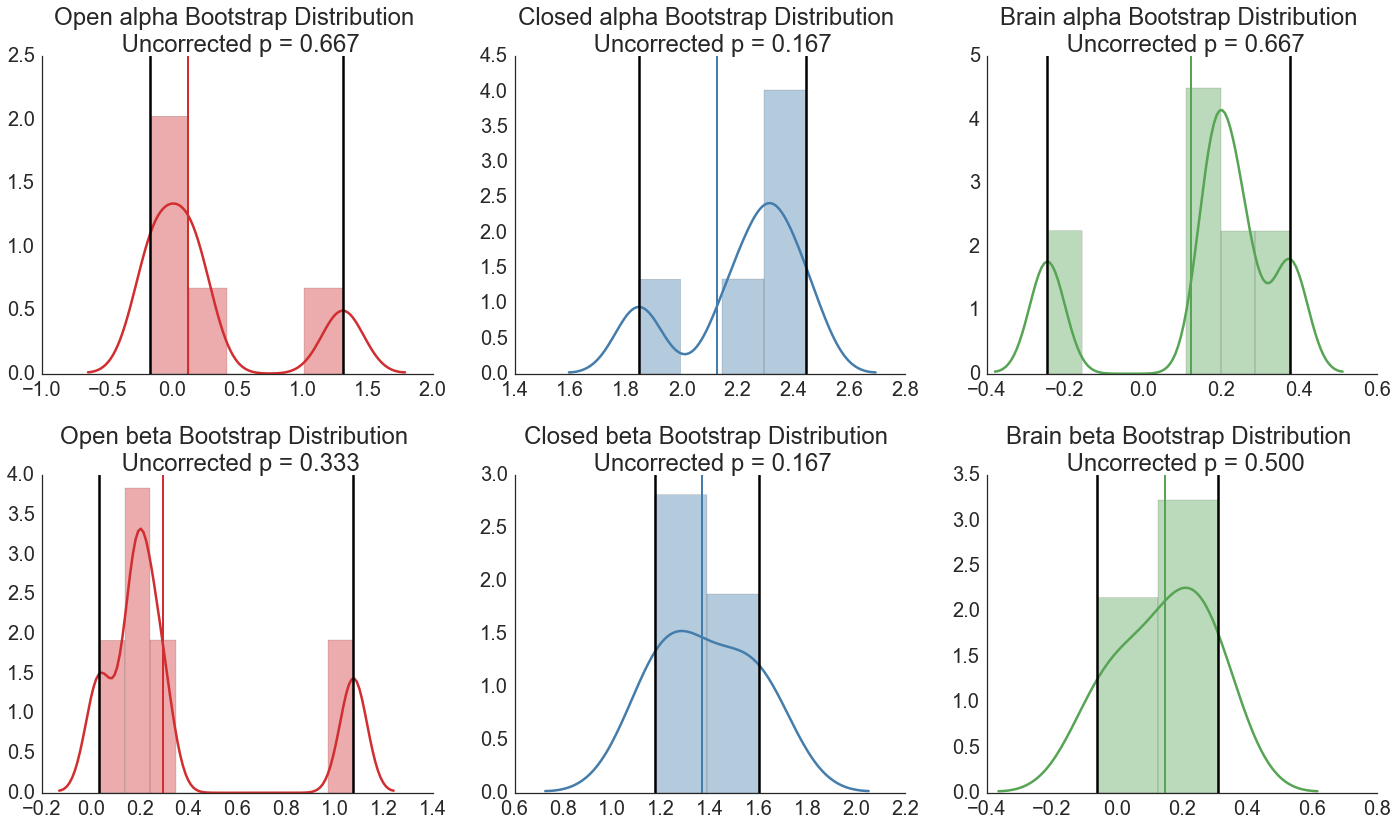

In [5]:
from plotting import plot_bootstrap_distributions

%matplotlib inline

fig = plot_bootstrap_distributions('saline')

f = '../plots/saline_experiment/saline_condition_bootstrap_distributions.png'
fig.savefig(f)
fig.show()

### Permutation Test for Comparing Conditions

#### Pre-Compute Permutation Indices 

In [ ]:
from supporting_functions import pre_compute_permutation_indices

pre_compute_permutation_indices('saline')

#### Pre-Compute Sub-Sample Indices

In [ ]:
from supporting_functions import pre_compute_subsample_indices

pre_compute_subsample_indices('saline')

#### Compute the Permutation Distributions

In [ ]:
from supporting_functions import compute_permutation_distributions

compute_permutation_distributions('saline')

#### Plot Permutation Distributions 

In [ ]:
from supporting_functions import plot_permutation_distributions

fig = plot_permutation_distributions('saline')
fig.savefig('./plots/saline_experiment/saline_condition_permutation_dists.png')
fig.show()

### Plot Condition TOI Comparison 

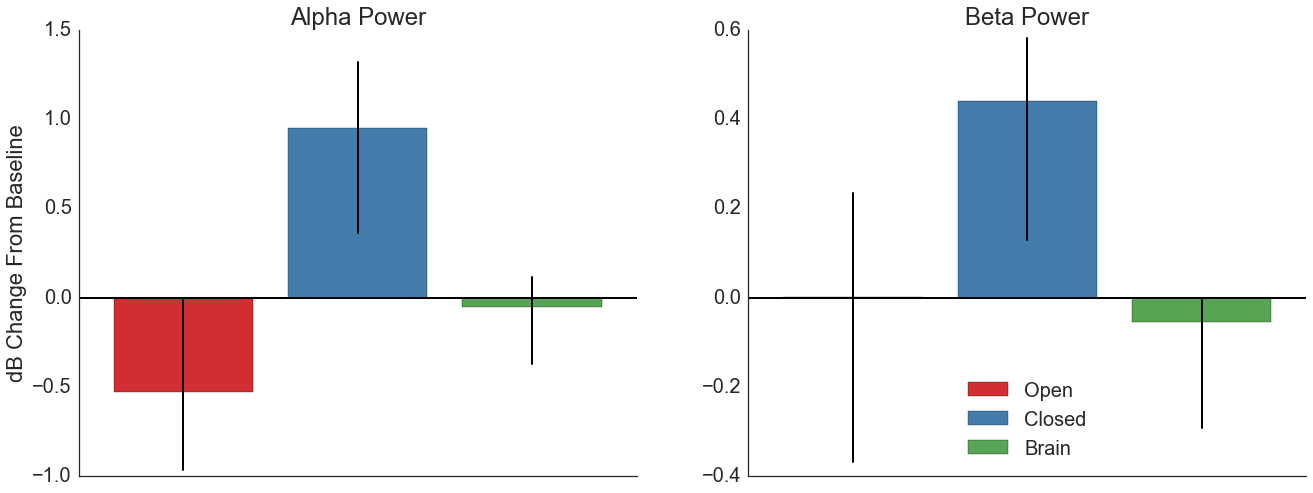

In [2]:
from plotting import plot_condition_toi_comparison

fig = plot_condition_toi_comparison('saline')
fig.savefig('../plots/saline_experiment/saline_condition_toi_comparison.png')

### Plot Condition Band Comparison 

/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


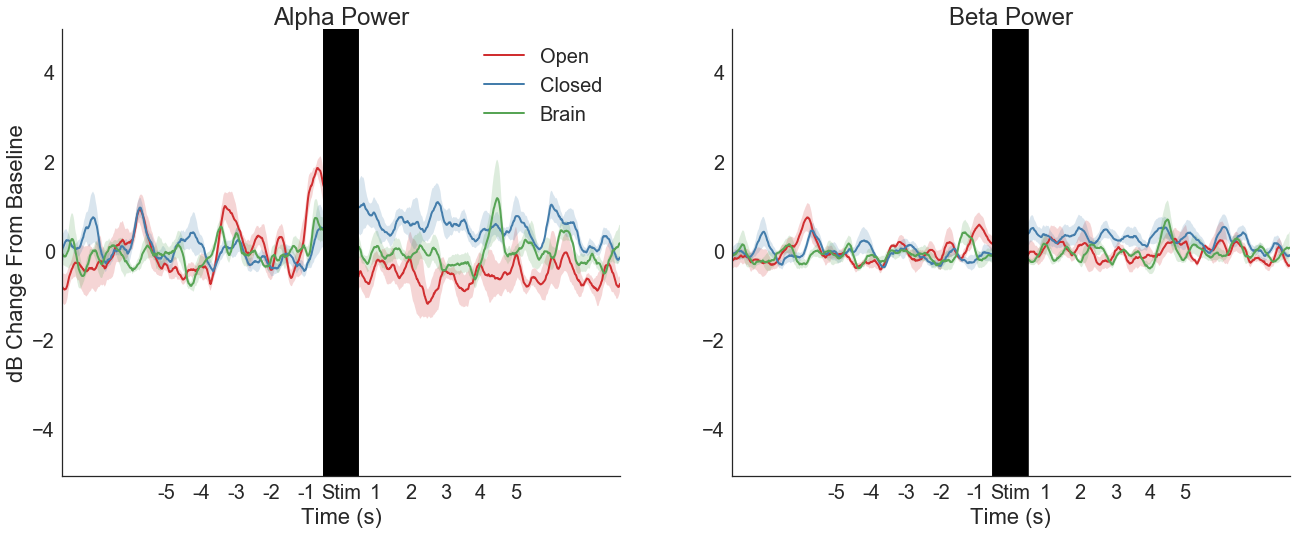

In [1]:
from plotting import plot_condition_band_comparison

%matplotlib inline

fig = plot_condition_band_comparison('saline')

fig.savefig("../plots/saline_experiment/saline_condition_band_comparison.png")
fig.show()

# Statistics 

## Generate Trial Normalized Bootstrap Distribution

Here we do a resampling bootstrap on the trial normalized spotlight band waveforms to get estimates of standard error of mean waveforms.

### Pregenerate Bootstrap Resampled Indices for Each Condition 

Saved to file so that the cell that actually computes the bootstrap distribution can read these in from file and be reproducible across different runs.
Thus this cell should only be run once.

In [38]:
import numpy as np

np.random.seed(2129)

bootstrap_indices = {}

conditions = ["Open", "Closed", "Brain"]
sample_sizes = [100, 100, 80]

num_bootstrap_samples = 5000

for ss, c in zip(sample_sizes, conditions):
    bootstrap_indices[c] = np.random.choice(ss, size=(num_bootstrap_samples, 
                                                      ss), replace=True)

out_dir = './stats/bootstrap'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
np.savez_compressed("%s/bootstrap_indices.npz" % out_dir, 
                    Open=bootstrap_indices["Open"], 
                    Closed=bootstrap_indices["Closed"], 
                    Brain=bootstrap_indices["Brain"], 
                    num_samples=num_bootstrap_samples)

### Compute the Bootstrap Distribution

In [3]:
import numpy as np
import glob

###############################
# Define Important Parameters #
###############################

bootstrap_indices = np.load("./stats/bootstrap/bootstrap_indices.npz")
num_bootstrap_samples = bootstrap_indices['num_samples']

conditions = ["Open", "Closed", "Brain"]

print("Bootstrapping for Array 1")

for condition in conditions:
    
    print("Computing Bootstrap Distribution for Condition: %s" %(condition))
    
    ######################################
    # Collect Date Data Within Condition #
    ######################################
    
    fnames = sorted(glob.glob("./power/raw/*%s*_raw_power.npz" %(condition)))
    
    tmp = np.load(fnames[0])
    times = tmp['times']
    chs = tmp['chs']
    freqs = tmp['freqs']
    
    raw_power = [np.load(f)['data'] for f in fnames]
    raw_power = np.concatenate(raw_power, axis=0)
    
    # Subsample to array 1
    arr1_ix = [ix for ix in np.arange(len(chs)) if 'elec1' in chs[ix] and chs[ix] != 'elec1-84' and chs[ix] != 'elec1-83']
    raw_power = raw_power[:, arr1_ix, :, :].squeeze()
    
    # Subsample to only frequencies in alpha and beta band
    freq_ix = np.where(np.logical_and(freqs >= 8, freqs <= 30)) 
    freqs = np.arange(8, 31) 
    raw_power = raw_power[:, :, freq_ix, :].squeeze()
    
    # Select out pre and post stimulation
    # Collapse stimulation into 0 and make pre and post stimulation times
    # relative to this 0 (so no longer 10 + for post stimulation)
    times = tmp['times']
    pre_mask = np.logical_and(times >= -5, times <= -.5)
    post_mask = np.logical_and(times >= 10.5, times <= 15)
    time_mask = np.where(np.logical_or(pre_mask, post_mask))[0]
    times = times[time_mask]
    times[times >= 10] -= 10
    raw_power = raw_power[:, :, :, time_mask].squeeze()
    
    ##################################
    # Loop Through Bootstrap Samples #
    ##################################
    
    bootstrap_cond_ix = bootstrap_indices[condition]
    
    alpha_bootstrap_samples = []
    beta_bootstrap_samples = []
    
    for i in range(num_bootstrap_samples):
        
        if (i+1) % 200 == 0:
            print("Bootstrap Sample # %d" %(i+1))
            
        bootstrap_ix = bootstrap_cond_ix[i, :]
        bootstrap_power = raw_power[bootstrap_ix, :, :, :]
        
        ###################
        # Normalize Power # 
        ###################

        # Power Normalizations are done according to Grandchamp & Delorme, 2011
        # Normalizations are done within condition, within electrode, within frequency

        # First Normalize Each Trial by Median of Entire Trial
        # I exclude -.5 -> .5 seconds around stimulation since these are contaminated
        # by stimulation edge artifact
        trial_bl = np.median(bootstrap_power, axis=-1)[:, :, :, np.newaxis]
        trial_norm_power = bootstrap_power / trial_bl

        # Then Median & Normalize Within Condition by Median of Pre-Stim Baseline Period
        baseline = (-5, -1)
        cond_power = np.median(trial_norm_power, axis=0)
        cond_bl_mask = np.where(np.logical_and(times >= baseline[0], times <= baseline[1]))
        cond_bl = np.median(cond_power[:, :, cond_bl_mask].squeeze(), axis=-1)[:, :, np.newaxis]
        cond_norm_power = cond_power / cond_bl

        # Finally, Log Transform & Scale for Decibels 
        cond_norm_power = 10 * np.log10(cond_norm_power)

        ######################
        # Extract Band Power # 
        ######################

        alpha = (8, 15)
        alpha_mask = np.where(np.logical_and(freqs >= alpha[0], freqs <= alpha[1]))
        beta = (15, 30)
        beta_mask = np.where(np.logical_and(freqs >= beta[0], freqs <= beta[1]))

        alpha_power = np.mean(cond_norm_power[:, alpha_mask, :].squeeze(), axis=1)
        beta_power = np.mean(cond_norm_power[:, beta_mask, :].squeeze(), axis=1)
    
        ###########################
        # Collapse Over Spotlight # 
        ###########################
        
        alpha_bootstrap_samples.append(np.mean(alpha_power, axis=0))
        beta_bootstrap_samples.append(np.mean(beta_power, axis=0))
    
    ##################################################
    # Save the Full Waveform Bootstrap Distributions # 
    ##################################################
    
    alpha_bootstrap_samples = np.vstack(alpha_bootstrap_samples)
    beta_bootstrap_samples = np.vstack(beta_bootstrap_samples)
    
    alpha_stderr = np.std(alpha_bootstrap_samples, axis=0)
    beta_stderr = np.std(beta_bootstrap_samples, axis=0)
    
    out_dir = './stats/bootstrap'
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    np.savez_compressed("%s/%s_bootstrap_distributions.npz" %(out_dir, 
                                                                 condition), 
                        alpha=alpha_bootstrap_samples, 
                        beta=beta_bootstrap_samples, 
                        alpha_stderr=alpha_stderr,
                        beta_stderr=beta_stderr, times=times)
    
print("Done!")

Boostrapping for Area: array1
Computing Bootstrap Distribution for Condition: Open
Bootstrap Sample # 200
Bootstrap Sample # 400
Bootstrap Sample # 600
Bootstrap Sample # 800
Bootstrap Sample # 1000
Bootstrap Sample # 1200
Bootstrap Sample # 1400
Bootstrap Sample # 1600
Bootstrap Sample # 1800
Bootstrap Sample # 2000
Bootstrap Sample # 2200
Bootstrap Sample # 2400
Bootstrap Sample # 2600
Bootstrap Sample # 2800
Bootstrap Sample # 3000
Bootstrap Sample # 3200
Bootstrap Sample # 3400
Bootstrap Sample # 3600
Bootstrap Sample # 3800
Bootstrap Sample # 4000
Bootstrap Sample # 4200
Bootstrap Sample # 4400
Bootstrap Sample # 4600
Bootstrap Sample # 4800
Bootstrap Sample # 5000
Computing Bootstrap Distribution for Condition: Closed
Bootstrap Sample # 200
Bootstrap Sample # 400
Bootstrap Sample # 600
Bootstrap Sample # 800
Bootstrap Sample # 1000
Bootstrap Sample # 1200
Bootstrap Sample # 1400
Bootstrap Sample # 1600
Bootstrap Sample # 1800
Bootstrap Sample # 2000
Bootstrap Sample # 2200
Bootst

### Perform Bootstrap Tests & FDR Corrections

In [4]:
import pylab as plt
import numpy as np
import seaborn as sns
from mne.stats import fdr_correction
sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')

conditions = ["Open", "Closed", "Brain"]

toi = (10.5, 11)

print("Bootstrapping for Array 1")

(f, axs) = plt.subplots(2, 3, figsize=(20, 16))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

cis = []
uncorrected_ps = []

for i, condition in enumerate(conditions):
    
    bootstrap_info = np.load("./stats/bootstrap/%s_bootstrap_distributions.npz" %(condition))
    alpha_dist = bootstrap_info['alpha']
    beta_dist = bootstrap_info['beta']
    
    actual_data = np.load("./power/trial_normalized_band_power/%s_trial_normalized_band_power.npz" %(condition))
    alpha_data = actual_data['alpha_power']
    beta_data = actual_data['beta_power']
    chs = actual_data['chs']
    arr_ix = [ix for ix in np.arange(len(chs)) if 'elec1' in chs[ix] and chs[ix] != 'elec1-84' and chs[ix] != 'elec1-83']
    
    alpha_data = alpha_data[arr_ix, :].squeeze().mean(axis=0)
    beta_data = beta_data[arr_ix, :].squeeze().mean(axis=0)
    
    times = bootstrap_info['times']
    toi_mask = np.where(np.logical_and(times >= toi[0], times <= toi[1]))
    
    alpha_toi_dist = np.sort(alpha_dist[:, toi_mask].squeeze().mean(axis=-1))
    beta_toi_dist = np.sort(beta_dist[:, toi_mask].squeeze().mean(axis=-1))
    
    alpha_toi = alpha_data[toi_mask].squeeze().mean()
    beta_toi = beta_data[toi_mask].squeeze().mean()
    
    lower_ix = int(len(alpha_toi_dist) * .025)
    upper_ix = int(len(alpha_toi_dist) * .975)
    
    alpha_ci = [alpha_toi_dist[lower_ix], alpha_toi_dist[upper_ix]]
    beta_ci = [beta_toi_dist[lower_ix], beta_toi_dist[upper_ix]]
    alpha_center_dist = alpha_toi_dist - alpha_toi
    beta_center_dist = beta_toi_dist - beta_toi
    alpha_p = (np.sum(np.abs(alpha_center_dist) >= np.abs(alpha_toi)) + 1.) / (len(alpha_toi_dist) + 1.)
    beta_p = (np.sum(np.abs(beta_center_dist) >= np.abs(beta_toi)) + 1.) / (len(beta_toi_dist) + 1.)
    
    ax = axs[0, i]
    sns.distplot(alpha_toi_dist, ax=ax, color=COLORS[i])
    ax.axvline(alpha_ci[0], color='k')
    ax.axvline(alpha_ci[1], color='k')
    ax.axvline(alpha_toi, color=COLORS[i], linewidth=2)
    ax.set_title("%s Alpha Bootstrap Distribution \n Uncorrected p = %.3f" %(condition, alpha_p))
    
    ax = axs[1, i]
    sns.distplot(beta_toi_dist, ax=ax, color=COLORS[i])
    ax.axvline(beta_ci[0], color='k')
    ax.axvline(beta_ci[1], color='k')
    ax.axvline(beta_toi, color=COLORS[i], linewidth=2)
    ax.set_title("%s Beta Bootstrap Distribution \n Uncorrected p = %.3f" %(condition, beta_p))
    
    uncorrected_ps.append(alpha_p)
    uncorrected_ps.append(beta_p)
    cis.append(alpha_ci)
    cis.append(beta_ci)
    

print("Uncorrected P-Values:")
print("Open Alpha: %.3f" %uncorrected_ps[0])
print("Open Beta: %.3f" %uncorrected_ps[1])
print("Closed Alpha: %.3f" %uncorrected_ps[2])
print("Closed Beta: %.3f" %uncorrected_ps[3])
print("Brain Alpha: %.3f" %uncorrected_ps[4])
print("Brain Beta: %.3f" %uncorrected_ps[5])
print("")

###################
# FDR Corrections #
###################
    
reject, fdr_ps = fdr_correction(uncorrected_ps, alpha=.05)
print("FDR Corrected P-Values:")
print("Open Alpha: %.3f" %fdr_ps[0])
print("Open Beta: %.3f" %fdr_ps[1])
print("Closed Alpha: %.3f" %fdr_ps[2])
print("Closed Beta: %.3f" %fdr_ps[3])
print("Brain Alpha: %.3f" %fdr_ps[4])
print("Brain Beta: %.3f" %fdr_ps[5])

for i, ax in enumerate(axs.flatten(order='F')):
    ax.set_xlabel("Corrected p = %.3f" %(fdr_ps[i]))

sns.despine()
plt.savefig("./plots/stats_distributions/array1_condition_bootstrap_distributions.png")

#################
# Save P-Values #
#################
    
np.savez_compressed("./stats/bootstrap/bootstrap_p_values.npz", 
                    uncorrected_p_values = uncorrected_ps, 
                    fdr_corrected_p_values = fdr_ps, 
                    reject=reject, cis=cis)
print("Done!")

Bootstrapping for Area: array1
Uncorrected P-Values:
Open Alpha: 0.066
Open Beta: 0.331
Closed Alpha: 0.379
Closed Beta: 0.973
Brain Alpha: 0.015
Brain Beta: 0.074

FDR Corrected P-Values:
Open Alpha: 0.149
Open Beta: 0.455
Closed Alpha: 0.455
Closed Beta: 0.973
Brain Alpha: 0.091
Brain Beta: 0.149
Done!


## Permutation Tests for Condition Differences in Post-Stim Power 

Permutations are done with trials across conditions. The permutations are used to build a distribution
for the difference in the mean spotlight power band activity from 0.5 - 1.5 seconds post-stim.

### Pre-Generate Permutation Indices

In [5]:
import numpy as np

np.random.seed(2129)

permutation_indices = {}

tests = ["Open-Closed", "Open-Brain", "Brain-Closed"]

num_permutations = 5000
sample_size = [100, 80, 80]

for ss, t in zip(sample_size, tests):
    permutations = np.zeros((num_permutations, ss * 2), dtype=np.int32)
    ix = np.arange(ss * 2)
    for i in range(num_permutations):
        np.random.shuffle(ix)
        permutations[i, :] = ix 
    permutation_indices[t] = permutations
    
out_dir = './stats/condition_permutations'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
np.savez_compressed("%s/stats/condition_permutations/permutation_indices.npz" % out_dir, 
                    Open_Closed=permutation_indices["Open-Closed"], 
                    Open_Brain=permutation_indices["Open-Brain"], 
                    Brain_Closed=permutation_indices["Brain-Closed"], 
                    num_permutations=num_permutations)

### Generate Random Indices to Equalize Trial Count Across Conditions

Since the brain condition was not collected on the first day, it only has 80 trials compared to 100 trials in the open
and closed condition. Here we randomly subsample 80 trials indices from the open and closed conditions to equalize trial count
for comparisons between conditions.

In [6]:
import numpy as np

np.random.seed(2129)

trial_indices = {}


conditions = ["Open", "Closed"]
num_permutations = 5000
original_sample_sizes = [100, 100]
desired_sample_sizes = [80, 80]

for oss, dss, c in zip(original_sample_sizes, desired_sample_sizes, conditions):
    trial_indices[c] = np.zeros((num_permutations, dss), dtype=np.int32)
    for i in range(num_permutations):
        trial_indices[c][i, :] = np.random.choice(oss, size=dss, replace=False)

np.savez_compressed("./stats/condition_permutations/trial_count_indices.npz", 
                    Open=trial_indices["Open"], Closed=trial_indices["Closed"])

### Compute the Permutation Distribution

In [9]:
import numpy as np
import glob
import pylab as plt
import seaborn as sns

sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')

###############################
# Define Important Parameters #
###############################

permutation_indices = np.load("./stats/condition_permutations/permutation_indices.npz")
num_permutations = permutation_indices['num_permutations']

comparisons = [["Open", "Closed"], ["Open", "Brain"], ["Brain", "Closed"]]

toi = (10.5, 11.0)

for comp in comparisons:
    conditions = comp

    print("Computing Permutation Distribution for Condition Comparison: %s-%s" %(conditions[0], conditions[1]))

    all_conditions_raw_power = {}

    for condition in conditions:

        ######################################
        # Collect Date Data Within Condition #
        ######################################

        fnames = sorted(glob.glob("./power/*%s*_raw_power.npz" %(condition)))

        tmp = np.load(fnames[0])
        times = tmp['times']
        chs = tmp['chs']
        freqs = tmp['freqs']

        raw_power = [np.load(f)['data'] for f in fnames]
        raw_power = np.concatenate(raw_power, axis=0)
        
        spot_ix = [ix for ix in np.arange(len(chs)) if 'elec1' in chs[ix] and chs[ix] != 'elec1-84' and chs[ix] != 'elec1-83']

        # Subsample to areas of interest for performance
        freq_ix = np.where(np.logical_and(freqs >= 8, freqs <= 30)) 
        freqs = np.arange(8, 31) 
        raw_power = raw_power[:, spot_ix, :, :].squeeze()
        raw_power = raw_power[:, :, freq_ix, :].squeeze()

        all_conditions_raw_power[condition] = raw_power


    #############################
    # Loop Through Permutations #
    #############################

    permutation_info = {}
    permutation_info['alpha_perm_dist'] = []
    permutation_info['beta_perm_dist'] = []

    permutation_cond_ix = permutation_indices["%s_%s"%(conditions[0], conditions[1])]
    trial_indices = np.load("./stats/condition_permutations/trial_count_indices.npz")

    for i in range(num_permutations + 1):

        if (i) % 200 == 0:
            print("Permutation # %d" %(i))

        ###############################################
        # Sub-select Trials to Match Condition Counts #
        ###############################################

        raw_power = []
        cond_shapes = []
        for c in conditions:
            power = all_conditions_raw_power[c]

            if i > 0 and "Brain" in conditions and c != "Brain":
                trial_ix = trial_indices[c][i-1, :]
                power = power[trial_ix, :, :, :].squeeze()

            cond_shapes.append(power.shape[0])
            raw_power.append(power)

        ######################################
        # Combine & Permute Condition Labels #
        ######################################

        raw_power = np.vstack(raw_power)
        del power

        # First Iteration Returns Us the Actual Statistic Value
        # Other Iterations Are Permutations
        if i == 0:
            perm_power = raw_power
        else:
            perm_ix = permutation_cond_ix[i-1, :]
            perm_power = raw_power[perm_ix, :, :, :].squeeze()

        alpha_tois = []
        beta_tois = []

        for j, cond in enumerate(conditions):

            if j == 0:
                cond_raw_power = perm_power[0:cond_shapes[0], :, :, :]
            else:
                cond_raw_power = perm_power[cond_shapes[0]:, :, :, :]

            ###################
            # Normalize Power # 
            ###################

            # Power Normalizations are done according to Grandchamp & Delorme, 2011
            # Normalizations are done within condition, within electrode, within frequency

            # First Normalize Each Trial by Median of Entire Trial
            # I exclude -.5 -> .5 seconds around stimulation since these are contaminated
            # by stimulation edge artifact
            trial_bl = np.median(cond_raw_power, axis=-1)[:, :, :, np.newaxis]
            trial_norm_power = cond_raw_power / trial_bl

            # Then Median & Normalize Within Condition by Median of Pre-Stim Baseline Period
            baseline = (-5, -1)
            cond_power = np.median(trial_norm_power, axis=0)
            cond_bl_mask = np.where(np.logical_and(times >= baseline[0], times <= baseline[1]))
            cond_bl = np.median(cond_power[:, :, cond_bl_mask].squeeze(), axis=-1)[:, :, np.newaxis]
            cond_norm_power = cond_power / cond_bl

            # Finally, Log Transform & Scale for Decibels 
            cond_norm_power = 10 * np.log10(cond_norm_power)

            ######################
            # Extract Band Power # 
            ######################

            alpha = (8, 15)
            alpha_mask = np.where(np.logical_and(freqs >= alpha[0], freqs <= alpha[1]))
            beta = (15, 30)
            beta_mask = np.where(np.logical_and(freqs >= beta[0], freqs <= beta[1]))

            alpha_power = np.mean(cond_norm_power[:, alpha_mask, :].squeeze(), axis=1)
            beta_power = np.mean(cond_norm_power[:, beta_mask, :].squeeze(), axis=1)

            ###########################
            # Collapse Over Spotlight # 
            ###########################

            alpha_power = np.mean(alpha_power, axis=0).squeeze()
            beta_power = np.mean(beta_power, axis=0).squeeze()

            #####################
            # Collapse Over TOI # 
            #####################

            toi_mask = np.where(np.logical_and(times >= toi[0], times <= toi[1]))

            alpha_tois.append(alpha_power[toi_mask].mean())
            beta_tois.append(beta_power[toi_mask].mean())

        ################################
        # Take Difference of TOI Means # 
        ################################

        if i == 0:
            permutation_info['alpha_diff'] = alpha_tois[0] - alpha_tois[1]
            permutation_info['beta_diff'] = beta_tois[0] - beta_tois[1]
        else:
            permutation_info['alpha_perm_dist'].append(alpha_tois[0] - alpha_tois[1])
            permutation_info['beta_perm_dist'].append(beta_tois[0] - beta_tois[1])

    ####################
    # Compute P-Values # 
    ####################

    permutation_info['alpha_p_value'] = (np.sum(np.abs(np.array(permutation_info['alpha_perm_dist'])) > np.abs(permutation_info['alpha_diff'])) + 1.) / (num_permutations + 1.)
    permutation_info['beta_p_value'] = (np.sum(np.abs(np.array(permutation_info['beta_perm_dist'])) > np.abs(permutation_info['beta_diff'])) + 1.) / (num_permutations + 1.)

#     #################################
#     # Plot Permutation Distribution #
#     #################################

#     f, axs = plt.subplots(1, 2, figsize=(18, 10))

#     sns.distplot(permutation_info['alpha_perm_dist'], ax=axs[0], color=COLORS[1])
#     axs[0].axvline(permutation_info['alpha_diff'], color=COLORS[1])
#     axs[0].set_title("Alpha Uncorrected p-value: %.2f"%permutation_info['alpha_p_value'])

#     sns.distplot(permutation_info['beta_perm_dist'], ax=axs[1], color=COLORS[1])
#     axs[1].axvline(permutation_info['beta_diff'], color=COLORS[1])
#     axs[1].set_title("Beta Uncorrected p-value: %.2f" %permutation_info['beta_p_value'])

#     plt.suptitle("%s-%s toi=(%.2f, %.2f)" %(conditions[0], conditions[1], toi[0], toi[1]))
#     sns.despine()
#     plt.savefig("./plots/%s-%s_toi=(%.2f,%.2f)_%s_permutation_dist.png"%(conditions[0], conditions[1], 
#                                                                          toi[0], toi[1], spotlight))

    ####################################
    # Save the Permutation Information # 
    ####################################

    np.savez_compressed("./stats/condition_permutations/%s-%s_toi=(%.2f,%.2f)_%s_permutation_info.npz" %(conditions[0], conditions[1], toi[0], toi[1], spotlight), alpha_dist = permutation_info['alpha_perm_dist'],
                        beta_dist = permutation_info['beta_perm_dist'], alpha_diff = permutation_info['alpha_diff'], beta_diff=permutation_info['beta_diff'],
                        num_permutations=num_permutations, alpha_p_value = permutation_info['alpha_p_value'], beta_p_value = permutation_info['beta_p_value'])

print("Done!")

Computing Permutation Distribution for Condition Comparison: Open-Closed
Permutation # 0
Permutation # 200
Permutation # 400
Permutation # 600
Permutation # 800
Permutation # 1000
Permutation # 1200
Permutation # 1400
Permutation # 1600
Permutation # 1800
Permutation # 2000
Permutation # 2200
Permutation # 2400
Permutation # 2600
Permutation # 2800
Permutation # 3000
Permutation # 3200
Permutation # 3400
Permutation # 3600
Permutation # 3800
Permutation # 4000
Permutation # 4200
Permutation # 4400
Permutation # 4600
Permutation # 4800
Permutation # 5000
Computing Permutation Distribution for Condition Comparison: Open-Brain
Permutation # 0
Permutation # 200
Permutation # 400
Permutation # 600
Permutation # 800
Permutation # 1000
Permutation # 1200
Permutation # 1400
Permutation # 1600
Permutation # 1800
Permutation # 2000
Permutation # 2200
Permutation # 2400
Permutation # 2600
Permutation # 2800
Permutation # 3000
Permutation # 3200
Permutation # 3400
Permutation # 3600
Permutation # 

### Permutation Tests & FDR Corrections 

In [10]:
from mne.stats import fdr_correction
import numpy as np

###################################
# Accumulate Permutation P-Values #
###################################

comparisons = ["Open-Closed", "Open-Brain", "Brain-Closed"]
toi=(0.5, 1.0)
spotlight="array1"
uncorrected_ps = []

(f, axs) = plt.subplots(2, 3, figsize=(20, 16))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

print("Computing Permutation Statistics for %s" %(spotlight))

for i, comp in enumerate(comparisons):
    perm_info = np.load("./stats/condition_permutations/%s_toi=(%.2f,%.2f)_%s_permutation_info.npz" %(comp, toi[0], toi[1], spotlight))
    
    
    #################################
    # Plot Permutation Distribution #
    #################################
    
    ax = axs[0, i]
    sns.distplot(perm_info['alpha_dist'], ax=ax)
    ax.axvline(perm_info['alpha_diff'], color=COLORS[1])
    ax.set_title("%s Alpha Power \n Uncorrected p = %.3f" %(comp, perm_info['alpha_p_value']))
    
    ax = axs[1, i]
    sns.distplot(perm_info['beta_dist'], ax=ax)
    ax.axvline(perm_info['beta_diff'], color=COLORS[1])
    ax.set_title("%s Beta Power \n Uncorrected p = %.3f" %(comp, perm_info['beta_p_value']))

    uncorrected_ps.append(perm_info['alpha_p_value'])
    uncorrected_ps.append(perm_info['beta_p_value'])

print("Uncorrected P-Values:")
print("Open-Closed Alpha: %.3f" %uncorrected_ps[0])
print("Open-Closed Beta: %.3f" %uncorrected_ps[1])
print("Open-Brain Alpha: %.3f" %uncorrected_ps[2])
print("Open-Brain Beta: %.3f" %uncorrected_ps[3])
print("Brain-Closed Alpha: %.3f" %uncorrected_ps[4])
print("Brain-Closed Beta: %.3f" %uncorrected_ps[5])
print("")

###################
# FDR Corrections #
###################
    
reject, fdr_ps = fdr_correction(uncorrected_ps, alpha=.05)
print("FDR Corrected P-Values:")
print("Open-Closed Alpha: %.3f" %fdr_ps[0])
print("Open-Closed Beta: %.3f" %fdr_ps[1])
print("Open-Brain Alpha: %.3f" %fdr_ps[2])
print("Open-Brain Beta: %.3f" %fdr_ps[3])
print("Brain-Closed Alpha: %.3f" %fdr_ps[4])
print("Brain-Closed Beta: %.3f" %fdr_ps[5])

for i, ax in enumerate(axs.flatten(order='F')):
    ax.set_xlabel("Corrected p = %.3f" %(fdr_ps[i]))

sns.despine()
plt.savefig("./plots/toi=(%.2f,%.2f)_%s_condition_permutation_dist.png"%(toi[0], toi[1], spotlight)) 

#################
# Save P-Values #
#################
    
np.savez_compressed("./stats/condition_permutations/toi=(%.2f,%.2f)_%s_condition_comparison_p_values.npz"%(toi[0], toi[1], spotlight), uncorrected_p_values = uncorrected_ps, fdr_corrected_p_values = fdr_ps, reject=reject)
print("Done!")

Computing Permutation Statistics for array1
Uncorrected P-Values:
Open-Closed Alpha: 0.041
Open-Closed Beta: 0.406
Open-Brain Alpha: 0.667
Open-Brain Beta: 0.617
Brain-Closed Alpha: 0.016
Brain-Closed Beta: 0.175

FDR Corrected P-Values:
Open-Closed Alpha: 0.122
Open-Closed Beta: 0.608
Open-Brain Alpha: 0.667
Open-Brain Beta: 0.667
Brain-Closed Alpha: 0.096
Brain-Closed Beta: 0.350
Done!


## Permutation Tests for Array Differences in Post-Stim Power

### Compute the Permutation Distribution 

In [13]:
import numpy as np
import glob
import pylab as plt
import seaborn as sns
import scipy.stats

sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')

conditions = ["Open", "Closed", "Brain"]

for condition in conditions:
    
    ######################################
    # Collect Date Data Within Condition #
    ######################################

    fnames = sorted(glob.glob("./power/*%s*_raw_power.npz" %(condition)))

    tmp = np.load(fnames[0])
    times = tmp['times']
    chs = tmp['chs']
    freqs = tmp['freqs']

    raw_power = [np.load(f)['data'] for f in fnames]
    cond_raw_power = np.concatenate(raw_power, axis=0)

    ###################
    # Normalize Power # 
    ###################

    # Power Normalizations are done according to Grandchamp & Delorme, 2011
    # Normalizations are done within condition, within electrode, within frequency

    # First Normalize Each Trial by Median of Entire Trial
    # I exclude -.5 -> .5 seconds around stimulation since these are contaminated
    # by stimulation edge artifact
    trial_bl = np.median(cond_raw_power, axis=-1)[:, :, :, np.newaxis]
    trial_norm_power = cond_raw_power / trial_bl

    # Then Median & Normalize Within Condition by Median of Pre-Stim Baseline Period
    baseline = (-5, -1)
    cond_power = np.median(trial_norm_power, axis=0)
    cond_bl_mask = np.where(np.logical_and(times >= baseline[0], times <= baseline[1]))
    cond_bl = np.median(cond_power[:, :, cond_bl_mask].squeeze(), axis=-1)[:, :, np.newaxis]
    cond_norm_power = cond_power / cond_bl

    # Finally, Log Transform & Scale for Decibels 
    cond_norm_power = 10 * np.log10(cond_norm_power)

    ######################
    # Extract Band Power # 
    ######################

    alpha = (8, 15)
    alpha_mask = np.where(np.logical_and(freqs >= alpha[0], freqs <= alpha[1]))
    beta = (15, 30)
    beta_mask = np.where(np.logical_and(freqs >= beta[0], freqs <= beta[1]))

    alpha_power = np.mean(cond_norm_power[:, alpha_mask, :].squeeze(), axis=1)
    beta_power = np.mean(cond_norm_power[:, beta_mask, :].squeeze(), axis=1)
    
    #############################
    # Loop Through Permutations #
    #############################

    permutation_info = {}
    permutation_info['alpha_perm_dist'] = []
    permutation_info['beta_perm_dist'] = []

    num_permutations = 5000
    np.random.seed(2129)

    print("Computing Permutation Distribution for Condition: %s" %(condition))

    for i in range(num_permutations + 1):

        ###########################
        # Shuffle Channel Indices #
        ###########################

        if i > 0:
            np.random.shuffle(chs)
        arr1_ix = [ix for ix in np.arange(len(chs)) if 'elec1' in chs[ix] and chs[ix] != 'elec1-84' and chs[ix] != 'elec1-83']
        arr2_ix = [ix for ix in np.arange(len(chs)) if 'elec2' in chs[ix]]


        #####################
        # Collapse Over TOI # 
        #####################

        toi = (0.5, 1.0)
        toi_mask = np.where(np.logical_and(times >= toi[0], times <= toi[1]))

        alpha_toi = alpha_power[:, toi_mask].mean(axis=-1)
        beta_toi = beta_power[:, toi_mask].mean(axis=-1)
        
        ####################################
        # Compute & Accumulate T-Statistic # 
        ####################################
        
        alpha_t, _ = scipy.stats.ttest_ind(alpha_toi[arr1_ix], alpha_toi[arr2_ix])
        beta_t, _ = scipy.stats.ttest_ind(beta_toi[arr1_ix], beta_toi[arr2_ix])

        if i == 0:
            permutation_info['alpha_diff'] = alpha_t 
            permutation_info['beta_diff'] = beta_t 
        else:
            permutation_info['alpha_perm_dist'].append(alpha_t)
            permutation_info['beta_perm_dist'].append(beta_t)

    ####################
    # Compute P-Values # 
    ####################

    permutation_info['alpha_p_value'] = (np.sum(np.abs(np.array(permutation_info['alpha_perm_dist'])) > np.abs(permutation_info['alpha_diff'])) + 1.) / (num_permutations + 1.)
    permutation_info['beta_p_value'] = (np.sum(np.abs(np.array(permutation_info['beta_perm_dist'])) > np.abs(permutation_info['beta_diff'])) + 1.) / (num_permutations + 1.)

#     #################################
#     # Plot Permutation Distribution #
#     #################################

#     f, axs = plt.subplots(1, 2, figsize=(18, 10))

#     sns.distplot(permutation_info['alpha_perm_dist'], ax=axs[0], color=COLORS[1])
#     axs[0].axvline(permutation_info['alpha_diff'], color=COLORS[1])
#     axs[0].set_title("Alpha Uncorrected p-value: %.2f"%permutation_info['alpha_p_value'])

#     sns.distplot(permutation_info['beta_perm_dist'], ax=axs[1], color=COLORS[1])
#     axs[1].axvline(permutation_info['beta_diff'], color=COLORS[1])
#     axs[1].set_title("Beta Uncorrected p-value: %.2f" %permutation_info['beta_p_value'])

#     plt.suptitle("%s Array1 vs. Array2 toi=(%.2f, %.2f)" %(condition, toi[0], toi[1]))
#     sns.despine()
#     plt.savefig("./plots/%s_array_toi=(%.2f,%.2f)_permutation_dist.png"%(condition, toi[0], toi[1]))

    ####################################
    # Save the Permutation Information # 
    ####################################

    np.savez_compressed("./stats/array_permutations/%s_toi=(%.2f,%.2f)_array_permutation_info.npz" %(condition, toi[0], toi[1]), alpha_dist = permutation_info['alpha_perm_dist'],
                        beta_dist = permutation_info['beta_perm_dist'], alpha_diff = permutation_info['alpha_diff'], beta_diff=permutation_info['beta_diff'],
                        num_permutations=num_permutations, alpha_p_value = permutation_info['alpha_p_value'], beta_p_value = permutation_info['beta_p_value'])

print("Done!")

Computing Permutation Distribution for Condition: Open
Computing Permutation Distribution for Condition: Closed
Computing Permutation Distribution for Condition: Brain
Done!


### Permutation Tests & FDR Corrections 

In [14]:
from mne.stats import fdr_correction
import numpy as np

###################################
# Accumulate Permutation P-Values #
###################################

conditions = ["Open", "Closed", "Brain"]
toi=(0.5, 1.0)
uncorrected_ps = []

(f, axs) = plt.subplots(2, 3, figsize=(20, 16))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

print("Computing Permutation Statistics for TOI=(%.2f, %.2f)" %(toi[0], toi[1]))

for i, condition in enumerate(conditions):
    perm_info = np.load("./stats/array_permutations/%s_toi=(%.2f,%.2f)_array_permutation_info.npz" %(condition, toi[0], toi[1]))
    uncorrected_ps.append(perm_info['alpha_p_value'])
    uncorrected_ps.append(perm_info['beta_p_value'])
    
    #################################
    # Plot Permutation Distribution #
    #################################
    
    ax = axs[0, i]
    sns.distplot(perm_info['alpha_dist'], ax=ax, color=COLORS[i])
    ax.axvline(perm_info['alpha_diff'], color=COLORS[i])
    ax.set_title("%s Alpha Power \n Uncorrected p = %.3f" %(condition, perm_info['alpha_p_value']))
    
    ax = axs[1, i]
    sns.distplot(perm_info['beta_dist'], ax=ax, color=COLORS[i])
    ax.axvline(perm_info['beta_diff'], color=COLORS[i])
    ax.set_title("%s Beta Power \n Uncorrected p = %.3f" %(condition, perm_info['beta_p_value']))

print("Uncorrected P-Values:")
print("Open Alpha: %.3f" %uncorrected_ps[0])
print("Open Beta: %.3f" %uncorrected_ps[1])
print("Closed Alpha: %.3f" %uncorrected_ps[2])
print("Closed Beta: %.3f" %uncorrected_ps[3])
print("Brain Alpha: %.3f" %uncorrected_ps[4])
print("Brain Beta: %.3f" %uncorrected_ps[5])
print("")

###################
# FDR Corrections #
###################
    
reject, fdr_ps = fdr_correction(uncorrected_ps, alpha=.05)
print("FDR Corrected P-Values:")
print("Open Alpha: %.3f" %fdr_ps[0])
print("Open Beta: %.3f" %fdr_ps[1])
print("Closed Alpha: %.3f" %fdr_ps[2])
print("Closed Beta: %.3f" %fdr_ps[3])
print("Brain Alpha: %.3f" %fdr_ps[4])
print("Brain Beta: %.3f" %fdr_ps[5])

for i, ax in enumerate(axs.flatten(order='F')):
    ax.set_xlabel("Corrected p = %.3f" %(fdr_ps[i]))

sns.despine()
plt.savefig("./plots/toi=(%.2f,%.2f)_array_permutation_dist.png"%(toi[0], toi[1])) 

#################
# Save P-Values #
#################
    
np.savez_compressed("./stats/array_permutations/toi=(%.2f,%.2f)_array_comparison_p_values.npz"%(toi[0], toi[1]), uncorrected_p_values = uncorrected_ps, fdr_corrected_p_values = fdr_ps, reject=reject)
print("Done!")

Computing Permutation Statistics for TOI=(0.50, 1.00)
Uncorrected P-Values:
Open Alpha: 0.000
Open Beta: 0.000
Closed Alpha: 0.012
Closed Beta: 0.000
Brain Alpha: 0.000
Brain Beta: 0.001

FDR Corrected P-Values:
Open Alpha: 0.000
Open Beta: 0.000
Closed Alpha: 0.012
Closed Beta: 0.000
Brain Alpha: 0.000
Brain Beta: 0.002
Done!


# Figures 

## Intuition

### Trial Normalized Band Power Across Entire Arrays

#### Preprocess Trial Normalized Band Power Into Arrays

This cell must be run prior to the ensuing cell so that the variable trial_power_struct is in memory.

In [58]:
import numpy as np
import pylab as plt
import seaborn as sns
import glob, re, os

sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')

% matplotlib inline

####################################
# Load Power & Reshape Into Arrays #
####################################

conditions = ["Open", "Closed", "Brain"]

trial_power_struct= {}

for c in conditions:
    print(c)
    
    tmp = np.load("./power/trial_normalized_band_power/%s_trial_normalized_band_power.npz" %(c))
    times = tmp['times']
    trial_power_struct['times'] = times
    chs = tmp['chs']
    
    for band in ["alpha", "beta"]:
        print(band)
        
        data = tmp["%s_power"%(band)]
        num_samples = data.shape[-1]
        
        # Add in zeros as placeholder for closed loop pair in array 1
        replace_ix = np.where(chs == 'elec1-83')
        data[replace_ix, :] = np.zeros(num_samples)
        replace_ix = np.where(chs == 'ref')
        data[replace_ix, :] = np.zeros(num_samples)
        chs[replace_ix] = 'elec1-84'
        
        ch_nums = [int(ch[ch.index('-') + 1:]) + int(ch[ch.index('-')-1]) * 1000 for ch in chs]
        sort_ix = np.argsort(ch_nums) 
        chs_sorted = chs[sort_ix]
        data = data[sort_ix, :]
        
        # Select out data for each array
        arr1_index = [ix for ix in np.arange(len(chs_sorted)) if 'elec1' in chs_sorted[ix]]
        arr2_index = [ix for ix in np.arange(len(chs_sorted)) if 'elec2' in chs_sorted[ix]]
        arr1_power = data[arr1_index, :]
        arr2_power = data[arr2_index, :]
        
        # Reshape to shape of electrode array
        arr1_power = np.reshape(arr1_power, (8, 8, num_samples))
        arr2_power = np.reshape(arr2_power, (8, 8, num_samples))
        
        # Reorient to Equal Actual Array Orientation
        for i in range(num_samples):
            arr1_power[:, :, i] = arr1_power[:, :, i].squeeze().T[::-1, :][:, ::-1]
            arr2_power[:, :, i] = arr2_power[:, :, i].squeeze().T[::-1, :][:, ::-1]
        
        # Store in persistent structure
        trial_power_struct['%s_%s_array1_power'%(c, band)] = arr1_power
        trial_power_struct['%s_%s_array2_power'%(c, band)] = arr2_power
        
print("Done!")    

Open
alpha
beta
Closed
alpha
beta
Brain
alpha
beta
Done!


#### Interactively Display Trial Normalized Array Band Power 

In [59]:
def plot_array_band_activity(time_ix, band):
    
    conditions = ["Open", "Closed", "Brain"]
    
    times = trial_power_struct['times']
    
    f, axs = plt.subplots(2, 3, figsize=(16, 14))
    plt.subplots_adjust(hspace=-.2, wspace=0.1)
    f.suptitle("Trial Normalized Power, T = %.3f s" %(times[time_ix]), fontsize=25, y=.90)
    vmin, vmax = -1, 1 
    
    for i, c in enumerate(conditions):
        
        ax = axs[0, i]
        data = trial_power_struct["%s_%s_array1_power"%(c, band)][:, :, time_ix].squeeze()
        mask = np.zeros((8, 8))
        mask[data == 0] = 1
        mask[data != 0] = np.nan
        ax.imshow(data, interpolation='nearest', cmap='RdBu_r', vmin=vmin, vmax=vmax)
        ax.imshow(mask, interpolation='nearest', vmin=.8, vmax=1)
        ax.set_title("Array 1 %s Alpha Power" %(c.capitalize()))
        ax.set_xticks(())
        ax.set_yticks(())
        
        ax = axs[1, i]
        data = trial_power_struct["%s_%s_array2_power"%(c, band)][:, :, time_ix].squeeze(),
        im = ax.imshow(data[0], interpolation='nearest', cmap='RdBu_r', vmin=vmin, vmax=vmax)
        ax.set_title("Array 2 %s Alpha Power" %(c.capitalize()))
        ax.set_xticks(())
        ax.set_yticks(())
    
    f.subplots_adjust(right=.88)
    cbar_ax = f.add_axes([0.9, 0.25, 0.05, 0.5])
    f.colorbar(im, cax=cbar_ax)
    
    plt.show()

In [60]:
from ipywidgets import interact
interact(plot_array_band_activity, time_ix = (0, num_samples, 10), band = ["alpha", "beta"])

<function __main__.plot_array_band_activity>

## Original Submission Manuscript Figures

### Trial Normalized Pre- and Post-Stimulation Array 1 Band Power

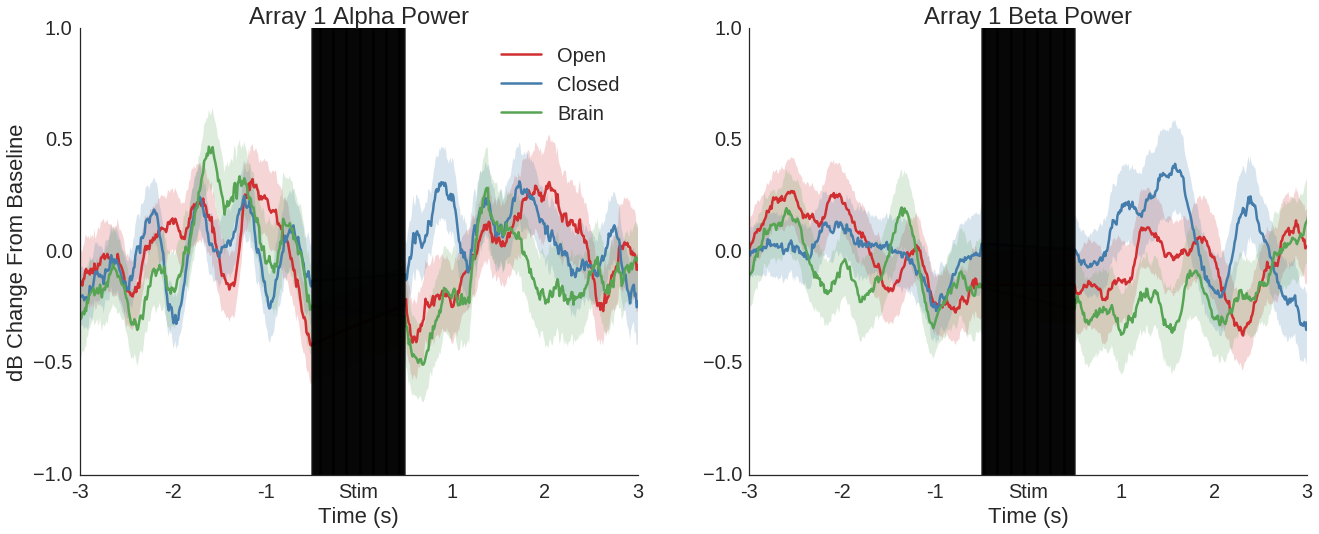

In [67]:
import numpy as np
import pylab as plt
import seaborn as sns
import glob, re, os

sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')

conditions = ["Open", "Closed", "Brain"]
bands = ["alpha", "beta"]

colors = COLORS[:3]
f, axs = plt.subplots(1, 2, figsize = (22, 8))

for color, c in zip(colors, conditions):
    
    tmp = np.load("./power/trial_normalized_band_power/%s_trial_normalized_band_power.npz" %(c))
    
    # Select out pre and post stimulation
    # Collapse stimulation into 0 and make pre and post stimulation times
    # relative to this 0 (so no longer 10 + for post stimulation)
    times = tmp['times']
    pre_mask = np.logical_and(times >= -5, times <= -.5)
    post_mask = np.logical_and(times >= 10.5, times <= 15)
    time_mask = np.where(np.logical_or(pre_mask, post_mask))[0]
    times = times[time_mask]
    times[times >= 10] -= 10
    
    chs = tmp['chs']
    err = np.load("./stats/submitted_for_manuscript/bootstrap/%s_array1_bootstrap_distributions.npz"%(c))
    
    arr_ix = [ix for ix in np.arange(len(chs)) if 'elec1' in chs[ix] and chs[ix] != 'elec1-84' and chs[ix] != 'elec1-83']
    
    for i, band in enumerate(bands):
        
        data = tmp["%s_power" %(band)]
        boot_std = err["%s_stderr"%(band)]
        
        array_data = np.median(data[arr_ix, :].squeeze(), axis=0).squeeze()
        array_data = array_data[time_mask]
        
        axs[i].plot(times, array_data, color=color)
        axs[i].fill_between(times, array_data - boot_std, array_data + boot_std, 
                            facecolor=color, alpha=0.2, edgecolor='none')
        
        axs[i].set_title("Array 1 %s Power" %(band.capitalize()))
        
        axs[i].set_xlabel("Time (s)")
        
        axs[i].set_ylim((-1, 1))
        axs[i].set_xticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
        axs[i].set_xticklabels([-5, -4, -3, -2, -1, 'Stim', 1, 2, 3, 4, 5])
        axs[i].set_xlim((-3, 3))
        
        sns.despine()
        
for i in np.arange(-.5, .5, .01):
    axs[0].axvline(i, color='k', alpha=0.8)
    axs[1].axvline(i, color='k', alpha=0.8)
axs[0].legend(conditions)
axs[0].set_ylabel("dB Change From Baseline")
        
f.savefig("./plots/manuscript_figures/array1_band_power.png")
plt.show()

###  Post Stimulation TOI Band Power

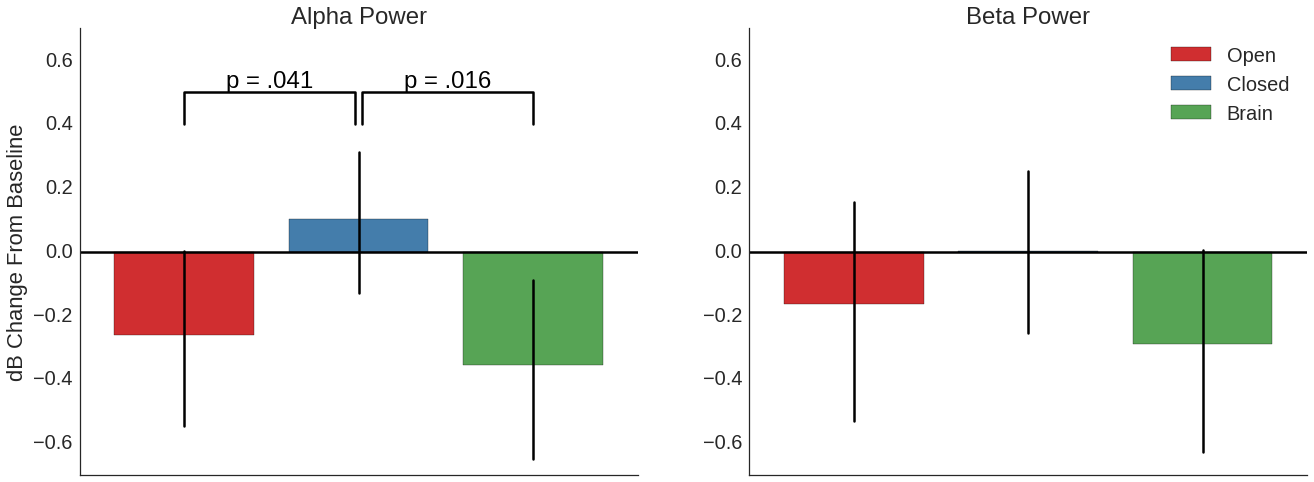

In [68]:
import numpy as np
import pylab as plt
import seaborn as sns
import glob, re, os

sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
colors = COLORS[:3]
plt.close('all')

conditions = ["Open", "Closed", "Brain"]
bands = ["alpha", "beta"]
toi = (10.5, 11.0) # 0.5 to 1 second post stimulation

f, axs = plt.subplots(1, 2, figsize = (22, 8))

# Get bootstrap confidence intervals
bootstrap_info = np.load("./stats/submitted_for_manuscript/bootstrap/toi=(%.2f,%.2f)_%s_bootstrap_p_values.npz" %(toi[0] - 10, toi[1]-10, 'array1'))
cis = bootstrap_info['cis']
k = 0

datas = []

for bar_ix, color, c in zip(range(1, len(conditions) + 1), colors, conditions):
    
    tmp = np.load("./power/trial_normalized_band_power/%s_trial_normalized_band_power.npz" %(c))
    times = tmp['times']
    chs = tmp['chs']
    
    arr_ix = [ix for ix in np.arange(len(chs)) if 'elec1' in chs[ix] and chs[ix] != 'elec1-84' and chs[ix] != 'elec1-83']
    toi_ix = np.where(np.logical_and(times > toi[0], times < toi[1]))
    
    for i, band in enumerate(bands):
        
        data = tmp["%s_power" %(band)]
        
        spotlight_data = np.mean(data[spot_ix, :].squeeze(), axis=0).squeeze()
        toi_data = spotlight_data[toi_ix].squeeze().mean()
        ci=cis[k]
        
        axs[i].bar(bar_ix, toi_data, color=color)
        axs[i].plot([bar_ix + .4, bar_ix + .4], ci, color='k', label='_nolegend_')
        
        axs[i].set_title("%s Power" %(band.capitalize()))
        
        axs[i].set_xlim((.8, 4))
        axs[i].set_ylim((-.7, .7))
        axs[i].set_xticks(())
        
        sns.despine()
        
        k += 1
        
axs[1].legend(conditions)
        
# Statistical Annotations
x1, x2 = 1.4, 2.38
y, h, col = .4, .1, 'k'
axs[0].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2.5, c=col)
axs[0].text((x1+x2)*.5, y+h, "p = .041", ha='center', va='bottom', color=col)

x1, x2 = 2.42, 3.4   
y, h, col = .4, .1, 'k'
axs[0].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2.5, c=col)
axs[0].text((x1+x2)*.5, y+h, "p = .016", ha='center', va='bottom', color=col)
        
axs[0].axhline(0, color='k')
axs[1].axhline(0, color='k')
axs[0].set_ylabel("dB Change From Baseline")
        
f.savefig("./plots/manuscript_figures/array1_toi_band_power.png")
plt.show()

### Trial Normalized Pre- and Post-Stimulation Band Power Array Comparisons

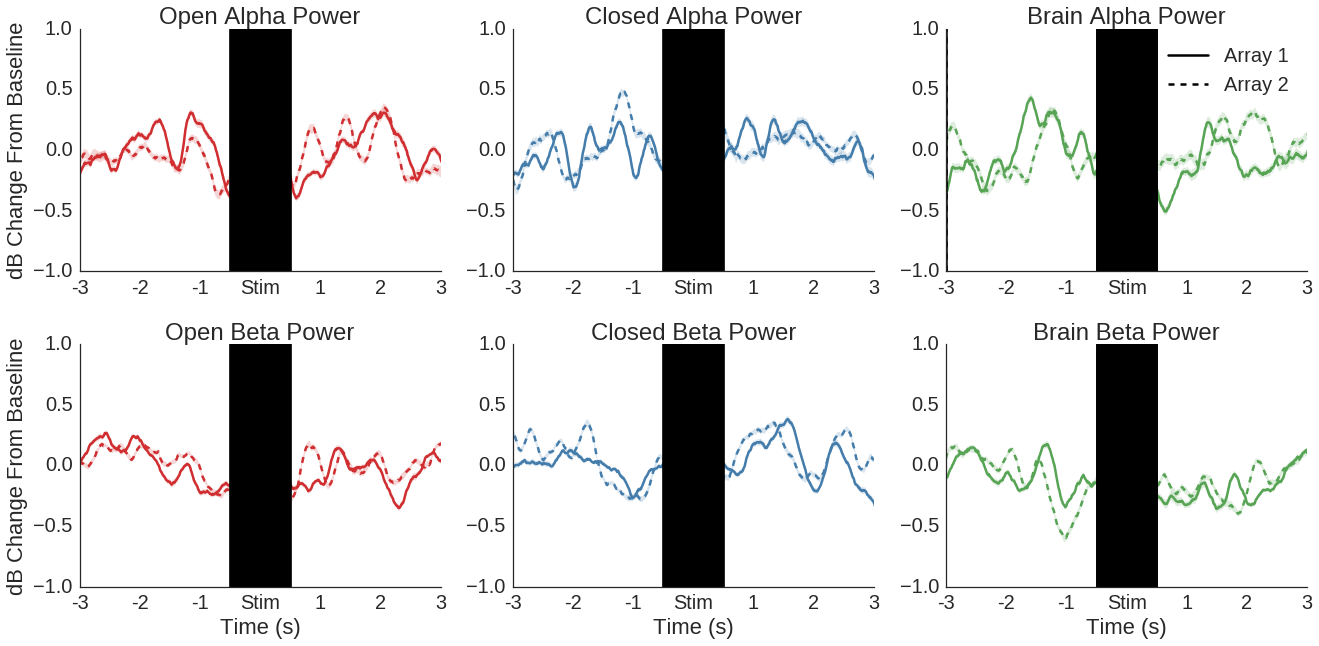

In [69]:
import numpy as np
import pylab as plt
import seaborn as sns
import glob, re, os

sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')

####################################
# Load Power & Reshape Into Arrays #
####################################

plt.close('all')

conditions = ["Open", "Closed", "Brain"]
bands = ["alpha", "beta"]

colors = COLORS[:3]
f, axs = plt.subplots(2, 3, figsize = (22, 10))
plt.subplots_adjust(hspace=.3)

for j, color, c in zip([0, 1, 2], colors, conditions):
    
    tmp = np.load("./power/trial_normalized_band_power/%s_trial_normalized_band_power.npz" %(c))
    
    # Select out pre and post stimulation
    # Collapse stimulation into 0 and make pre and post stimulation times
    # relative to this 0 (so no longer 10 + for post stimulation)
    times = tmp['times']
    pre_mask = np.logical_and(times >= -5, times <= -.5)
    post_mask = np.logical_and(times >= 10.5, times <= 15)
    time_mask = np.where(np.logical_or(pre_mask, post_mask))[0]
    times = times[time_mask]
    times[times >= 10] -= 10
    
    chs = tmp['chs']
    arr1_ix = [ix for ix in np.arange(len(chs)) if 'elec1' in chs[ix] and chs[ix] != 'elec1-84' and chs[ix] != 'elec1-83']
    arr2_ix = [ix for ix in np.arange(len(chs)) if 'elec2' in chs[ix]]
    
    for i, band in enumerate(bands):
        
        data = tmp["%s_power" %(band)]
        data = data[:, time_mask]
        arr1_data = np.mean(data[arr1_ix, :].squeeze(), axis=0).squeeze()
        arr2_data = np.mean(data[arr2_ix, :].squeeze(), axis=0).squeeze()
        arr1_std_err = np.std(data[arr1_ix, :].squeeze(), axis=0).squeeze() / np.sqrt(data[arr1_ix, :].squeeze().shape[0])
        arr2_std_err = np.std(data[arr2_ix, :].squeeze(), axis=0).squeeze() / np.sqrt(data[arr2_ix, :].squeeze().shape[0])
        
        axs[i, j].plot(times, arr1_data, color=color, label="_nolegend_")
        axs[i, j].plot(times, arr2_data, color=color, linestyle='--', label="_nolegend_")
        axs[i, j].fill_between(times, arr1_data - arr1_std_err, arr1_data + arr1_std_err, facecolor=color, alpha=0.2, edgecolor='none')
        axs[i, j].fill_between(times, arr2_data - arr2_std_err, arr2_data + arr2_std_err, facecolor=color, alpha=0.2, edgecolor='none')
        
        axs[i, j].set_title("%s %s Power" %(c, band.capitalize()))
        
        axs[i, j].set_xlim((-3, 3))
        axs[i, j].set_xticks([-3, -2, -1, 0, 1, 2, 3])
        axs[i, j].set_xticklabels([-3, -2, -1, 'Stim', 1, 2, 3])
        
        axs[i, j].set_ylim((-1, 1))
        
        sns.despine()
        
        for x in np.arange(-.5, .5, .01):
            axs[i, j].axvline(x, color='k', alpha=0.8, label="_nolegend_")
            axs[i, j].axvline(x, color='k', alpha=0.8, label="_nolegend_")

axs[0, 2].axvline(-3, color='k')
axs[0, 2].axvline(-3, color='k', linestyle='--')
axs[0, 2].legend(["Array 1", "Array 2"])
axs[0, 0].set_ylabel("dB Change From Baseline")
axs[1, 0].set_ylabel("dB Change From Baseline")
axs[1, 0].set_xlabel("Time (s)")
axs[1, 1].set_xlabel("Time (s)")
axs[1, 2].set_xlabel("Time (s)")
        
f.savefig("./plots/manuscript_figures/array_comparison_band_power.png")
plt.show()

###  Post Stimulation TOI Band Power Array Comparisons

Open
alpha
Array 1 Mean: -0.260, Array 2 Mean: -0.028
beta
Array 1 Mean: -0.165, Array 2 Mean: 0.001
Closed
alpha
Array 1 Mean: 0.100, Array 2 Mean: -0.007
beta
Array 1 Mean: 0.005, Array 2 Mean: 0.097
Brain
alpha
Array 1 Mean: -0.351, Array 2 Mean: -0.092
beta
Array 1 Mean: -0.289, Array 2 Mean: -0.169


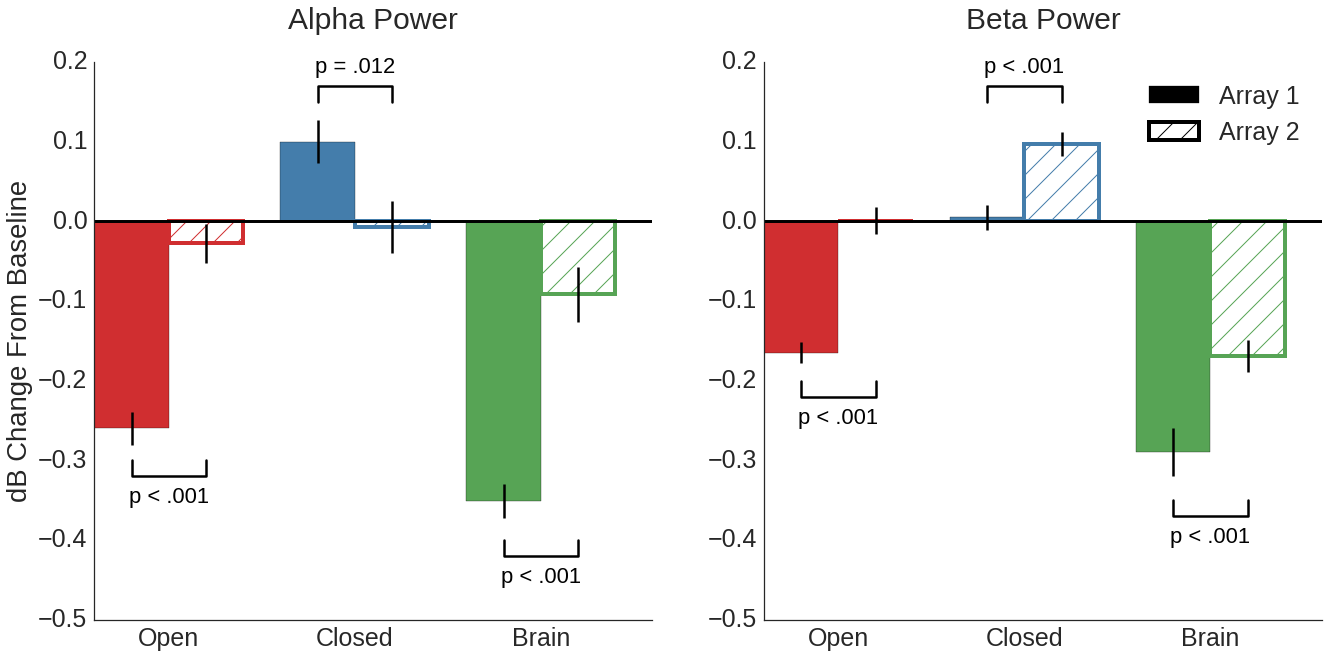

In [70]:
import numpy as np
import pylab as plt
import seaborn as sns
import glob, re, os


sns.set(style="white", font_scale=2.5, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')

####################################
# Load Power & Reshape Into Arrays #
####################################

plt.close('all')

conditions = ["Open", "Closed", "Brain"]
bands = ["alpha", "beta"]
toi = (10.5, 11.0)

colors = COLORS[:3]
f, axs = plt.subplots(1, 2, figsize = (22, 10))
plt.subplots_adjust(hspace=.3)

xticks = [0, 2, 4]
xticklabels = conditions

for bar_ix, c in zip(xticks, conditions):
    
    tmp = np.load("./power/trial_normalized_band_power/%s_trial_normalized_band_power.npz" %(c))
    times = tmp['times']
    chs = tmp['chs']
    print(c)
    
    
    arr1_ix = [ix for ix in np.arange(len(chs)) if 'elec1' in chs[ix] and chs[ix] != 'elec1-84' and chs[ix] != 'elec1-83']
    arr2_ix = [ix for ix in np.arange(len(chs)) if 'elec2' in chs[ix]]
    toi_ix = np.where(np.logical_and(times >= toi[0], times <= toi[1]))
    
    for i, band in enumerate(bands):
        
        data = tmp["%s_power" %(band)]
        arr1_data = data[arr1_ix, :].squeeze()
        arr1_data = arr1_data[:, toi_ix].squeeze().mean(axis=-1).squeeze()
        arr2_data = data[arr2_ix, :].squeeze()
        arr2_data = arr2_data[:, toi_ix].squeeze().mean(axis=-1).squeeze()
        arr1_mean = arr1_data.mean()
        arr2_mean = arr2_data.mean()
        arr1_std_err = arr1_data.std()/np.sqrt(len(arr1_data))
        arr2_std_err = arr2_data.std()/np.sqrt(len(arr2_data))
        print(band)
        print("Array 1 Mean: %.3f, Array 2 Mean: %.3f" %(arr1_mean, arr2_mean))
        
        axs[i].bar(bar_ix, arr1_mean, color=colors[bar_ix//2], yerr=arr1_std_err, ecolor='k')
        axs[i].bar(bar_ix + .8, arr2_mean, facecolor='none', edgecolor=colors[bar_ix//2], linewidth=4,
                   yerr=arr2_std_err, ecolor='k', hatch='/')
        
        
        axs[i].set_xticks([x + .8 for x in xticks])
        axs[i].set_xticklabels(xticklabels)
        axs[i].set_xlim((0, 6))
        axs[i].set_ylim((-.5, .2))
        
        axs[i].set_title("%s Power" %(band.capitalize()), y=1.05)
        axs[i].axhline(0, color='k', label="_nolegend_")
        
        sns.despine()
        
axs[0].set_ylabel("dB Change From Baseline")

axs[1].legend(["Array 1", "Array 2"])
leg = axs[1].get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_edgecolor('black')

# Statistical Annotations
x1, x2 = .4, 1.2
y, h, col = -.3, .02, 'k'
axs[0].plot([x1, x1, x2, x2], [y, y-h, y-h, y], lw=2.5, c=col)
axs[0].text((x1+x2)*.5, y-3*h, "p < .001", ha='center', va='bottom', color=col, size=22)

x1, x2 = 2.4, 3.2   
y, h, col = .15, .02, 'k'
axs[0].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2.5, c=col)
axs[0].text((x1+x2)*.5, y+1.5*h, "p = .012", ha='center', va='bottom', color=col, size=22)

x1, x2 = 4.4, 5.2   
y, h, col = -.4, .02, 'k'
axs[0].plot([x1, x1, x2, x2], [y, y-h, y-h, y], lw=2.5, c=col)
axs[0].text((x1+x2)*.5, y-3*h, "p < .001", ha='center', va='bottom', color=col, size=22)

x1, x2 = .4, 1.2
y, h, col = -.2, .02, 'k'
axs[1].plot([x1, x1, x2, x2], [y, y-h, y-h, y], lw=2.5, c=col)
axs[1].text((x1+x2)*.5, y-3*h, "p < .001", ha='center', va='bottom', color=col, size=22)

x1, x2 = 2.4, 3.2   
y, h, col = .15, .02, 'k'
axs[1].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2.5, c=col)
axs[1].text((x1+x2)*.5, y+1.5*h, "p < .001", ha='center', va='bottom', color=col, size=22)

x1, x2 = 4.4, 5.2   
y, h, col = -.35, .02, 'k'
axs[1].plot([x1, x1, x2, x2], [y, y-h, y-h, y], lw=2.5, c=col)
axs[1].text((x1+x2)*.5, y-3*h, "p < .001", ha='center', va='bottom', color=col, size=22)
        
f.savefig("./plots/manuscript_figures/array_comparison_toi_band_power.png")
plt.show()

## Revisions 

### Spectrogram of Before, During, After Stimulation

In response to the reviewer's request, we plot the full spectrograms (averaged TFR) of data before during and after stimulation.

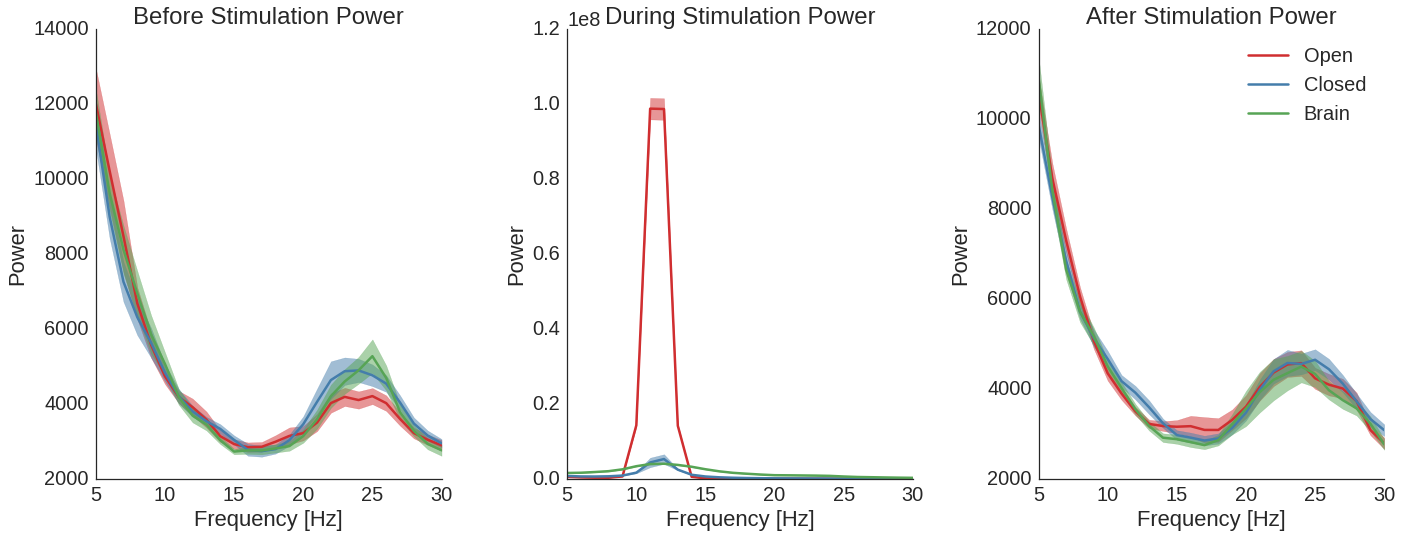

In [18]:
import numpy as np
import os, glob, re
import pylab as plt
import seaborn as sns

sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')

indices = {'Before': (-1, -.5), 'During': (0, 10), 'After': (10.5, 11)}
conditions = ['Open', 'Closed', 'Brain']
colors = COLORS[:3]

num_bootstraps = 1000
        
f, axs = plt.subplots(1, 3, figsize=(20, 8))

for i, time_period in enumerate(['Before', 'During', 'After']):
    
    ax = axs[i]
    
    for j, condition in enumerate(conditions):
    
        fnames = sorted(glob.glob("./power/raw/ns2*%s*_raw_power.npz" % condition))
        
        tmp = np.load(fnames[0])
        times = tmp['times']
        chs = tmp['chs']
        freqs = tmp['freqs']

        # Collect Date Data Within Conditions
        raw_power = [np.load(f)['data'] for f in fnames]
        raw_power = np.concatenate(raw_power, axis=0)
    
        # Crop out period of interest
        arr_ix = [ix for ix in np.arange(len(chs)) if 'elec1-83' not in chs[ix] and 'elec1-84' not in chs[ix]]
        time_mask = np.where(np.logical_and(times >= indices[time_period][0],
                                            times <= indices[time_period][1]))
    
        # Collapse across array and time
        arr_data = raw_power[:, arr_ix, :, :].mean(axis=1).squeeze()
        arr_data = arr_data[:, :, time_mask].mean(axis=-1).squeeze()
        
        # Generate bootstrap distribution for standard error
        num_trials = arr_data.shape[0]
        num_freqs = arr_data.shape[1]
        bootstrap_indices = np.random.choice(num_trials, 
                                             size=(num_bootstraps, 
                                                   num_trials),
                                             replace=True)    
        bootstrap_samples = np.zeros((num_bootstraps, num_trials, num_freqs))
        for i in range(num_bootstraps):
            bootstrap_samples[i, :, :] = arr_data[bootstrap_indices[i, :], :]
            
        # Collapse across trials 
        bootstrap_samples = bootstrap_samples.mean(axis=1)
        arr_data = arr_data.mean(axis=0)
        
        # Collect standarde deviation of bootstrap
        bootstrap_std = bootstrap_samples.std(axis=0)
        
        ax.plot(freqs, arr_data, color=colors[j])
        ax.fill_between(freqs, arr_data - bootstrap_std, 
                        arr_data + bootstrap_std, color=colors[j],
                        alpha=0.5, label='_nolegend_')

    ax.set_title('%s Stimulation Power' % time_period)

    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Power')

axs[-1].legend(conditions)
plt.tight_layout()
sns.despine()
plt.savefig('./plots/manuscript_figures/before_during_after_spectrum.png')
plt.show()

### Early vs. Late Stimulation Spectrum

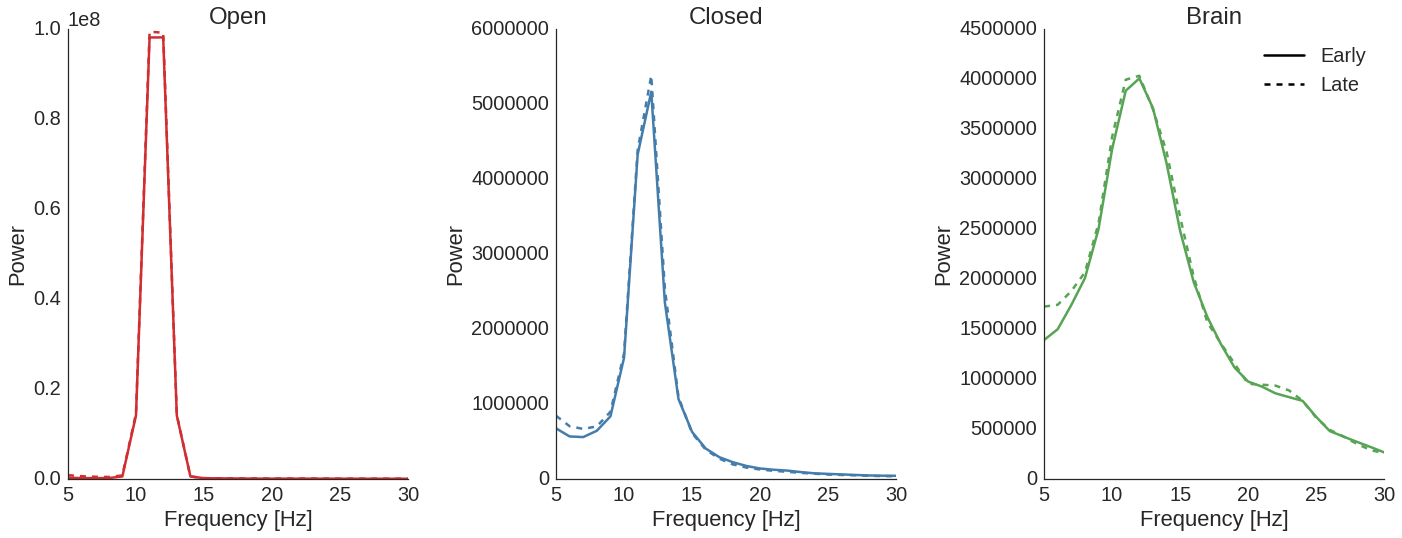

In [13]:
import numpy as np
import os, glob, re
import pylab as plt
import seaborn as sns

sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')

indices = {'Early': (0, 5), 'Late': (5, 10)}
conditions = ['Open', 'Closed', 'Brain']
colors = COLORS[:3]
linestyles=['-', '--']
        
f, axs = plt.subplots(1, 3, figsize=(20, 8))

for i, condition in enumerate(conditions):
    
    ax = axs[i]
    fnames = sorted(glob.glob("./power/raw/ns2*%s*_raw_power.npz" % condition))
    
    tmp = np.load(fnames[0])
    times = tmp['times']
    chs = tmp['chs']
    freqs = tmp['freqs']

    # Collect Date Data Within Conditions
    raw_power = [np.load(f)['data'] for f in fnames]
    raw_power = np.concatenate(raw_power, axis=0)
    
    arr_ix = [ix for ix in np.arange(len(chs)) if 'elec1-83' not in chs[ix] and 'elec1-84' not in chs[ix]]
    arr_data = raw_power.mean(axis=0)
    arr_data = arr_data[arr_ix, :, :].mean(axis=0)
    
    for j, time_period in enumerate(['Early', 'Late']):
        
        # Crop out period of interest
        time_mask = np.where(np.logical_and(times >= indices[time_period][0],
                                            times <= indices[time_period][1]))
    
        data = arr_data[:, time_mask].mean(axis=-1)

        ax.plot(freqs, data, color=colors[i], linestyle=linestyles[j])

    ax.set_title(condition)
    if i == 2:
        ax.legend(['Early', 'Late'])
        leg = ax.get_legend()
        leg.legendHandles[0].set_color('black')
        leg.legendHandles[1].set_color('black')
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Power')
            
plt.tight_layout()
sns.despine()
plt.savefig('./plots/manuscript_figures/early_vs_late_stimulation_spectrum.png')
plt.show()

#### Raw Time Courses of Controlling Electrode During Stimulation

In [5]:
import glob, re
import pandas as pd
from mne import read_epochs
from ipywidgets import interact
import numpy as np
import pylab as plt
import seaborn as sns

condition_df = pd.read_csv("./lab_notebook/condition_info.csv", 
                           dtype={"Date":str, "Trial":int, "Block":int, 
                                  "Condition":int})
dates = condition_df.Date.unique()
conditions = ['Open', 'Closed', 'Brain']

# Preload data

# 09012016, 09022016, 09062016, 09072016
date = '09022016'
ns2_epochs = read_epochs('./epochs/%s_ns2_stim_onset-epo.fif' % date)
ns5_epochs = read_epochs('./epochs/%s_ns5_stim_onset-epo.fif' % date)
times = ns2_epochs.times
stim_mask = np.where(np.logical_and(times >= 0, times <= 10))[0]

# Subselect
ns2_epochs.pick_channels(['elec1-83'])
ns2_data = ns2_epochs.get_data().squeeze()
ns2_data = ns2_data[:, stim_mask]
ns5_epochs.pick_channels(['ainp2'])
ns5_data = ns5_epochs.get_data().squeeze()
ns5_data = ns5_data[:, stim_mask]

In [8]:
def plot_time_course(trial):
    
    plt.figure(figsize=(20, 6))
    date_df = condition_df[condition_df.Date == date]
    plt.plot(ns2_data[trial - 1, :])
    plt.plot(ns5_data[trial - 1, :])
    condition = conditions[date_df.iloc[trial-1, -1]]
    block = condition_df.iloc[trial-1, -2]
    plt.title('Date: %s, Condition: %s' % (date, condition))
    plt.xlabel('Time [ms]')
    plt.legend(['Control Signal', 'Stimulation'])
    sns.despine()
    plt.show()
    
interact(plot_time_course, trial = (1, ns2_data.shape[0], 1)) 

<function __main__.plot_time_course>

#### Raw Spectrograms of Controlling Electrode During Stimulation

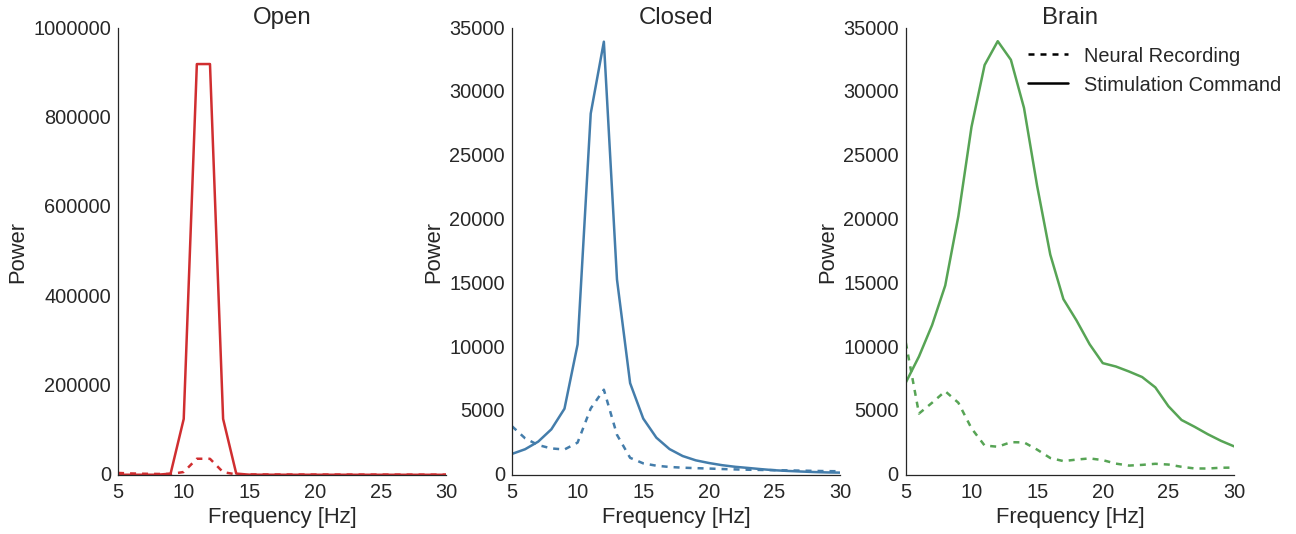

In [14]:
import pylab as plt
import seaborn as sns
import numpy as np
import glob

sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')

indices = {'Before': (-1, -.5), 'During': (0, 10), 'After': (10.5, 11)}
conditions = ['Open', 'Closed', 'Brain']
colors = COLORS[:3]
        
f, axs = plt.subplots(1, 3, figsize=(20, 8))

conditions = ["Open", "Closed", "Brain"]
types = ['ns2', 'ns5']
legend = ['Neural Recording', 'Stimulation Command']

for i, condition in enumerate(conditions):
    
    ax = axs[i]
    
    for typ in types:
    
        fnames = sorted(glob.glob("./power/raw/%s*%s*_raw_power.npz" %(typ, condition)))
        tmp = np.load(fnames[0])
        times = tmp['times']
        chs = tmp['chs']
        freqs = tmp['freqs']

        # Collect Date Data Within Conditions
        raw_power = [np.load(f)['data'] for f in fnames]
        raw_power = np.concatenate(raw_power, axis=0)

        if typ == 'ns2':
            ch_ix = [ix for ix in np.arange(len(chs)) if 'elec1-83' in chs[ix]]
            linestyle='--'
        else:
            ch_ix = [ix for ix in np.arange(len(chs)) if 'ainp2' in chs[ix]]
            linestyle='-'
            
        raw_power = raw_power[:, ch_ix, :, :].squeeze()
        raw_power = raw_power.mean(axis=0).mean(axis=-1)

        ax.plot(freqs, raw_power, color=colors[i], linestyle=linestyle)
        ax.set_title(condition)
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Power')
    if i == 2:
        ax.legend(legend, bbox_to_anchor=(1.2, 1))
        leg = ax.get_legend()
        leg.legendHandles[0].set_color('black')
        leg.legendHandles[1].set_color('black')

sns.despine()
plt.savefig('./plots/manuscript_figures/controlling_stimulation_spectrum.png')
plt.show()